In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [97]:
path = '/content/drive/My Drive/Colab Notebooks/NgramModel/'

#############################################
# LOAD DATA
#############################################

def read_imdb_data(base_path, sub_path):
    data = []
    path = os.path.join(base_path, sub_path)
    for label in ['pos', 'neg']:
        for file in os.listdir(os.path.join(path, label)):
            with open(os.path.join(path, label, file), 'r', encoding='utf-8') as f:
                data.append((f.read(), label))
    return data

train_data = read_imdb_data(path, 'aclImdb/train')
test_data = read_imdb_data(path, 'aclImdb/test')

def read_tweet_eval_data(base_path, sub_path):
    path = os.path.join(base_path, sub_path)
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        stripped_lines = []
        for line in lines:
            stripped_line = line.strip()
            stripped_lines.append(stripped_line)
        return stripped_lines

tweet_eval_train = read_tweet_eval_data(path, 'tweeteval/datasets/emotion/train_text.txt')
tweet_eval_test = read_tweet_eval_data(path, 'tweeteval/datasets/emotion/test_text.txt')

print(tweet_eval_train[:1])

def read_wikitext_data(base_path, sub_path):
    path = os.path.join(base_path, sub_path)
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        stripped_lines = []
        for line in lines:
            stripped_line = line.strip()
            stripped_lines.append(stripped_line)
        return stripped_lines

wikitext_train = read_wikitext_data(path, 'wikitext-103/wiki.train.tokens')
wikitext_test = read_wikitext_data(path, 'wikitext-103/wiki.test.tokens')

print(wikitext_train[:2])

["“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry"]
['', '= Valkyria Chronicles III =']


In [25]:
#############################################
# PREPROCESS DATA
#############################################
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

nltk.download('punkt')

# WikiText

# only the first 1000 articles
wiki_text = wikitext_train[:1000]

# into sentences
wiki_sentences = []
for text in wiki_text:
    text_sentences = sent_tokenize(text)
    wiki_sentences.extend(text_sentences)

# into words
wiki_tokenized_sentences = []
for sentence in wiki_sentences:
    tokenized_sentence = word_tokenize(sentence)
    wiki_tokenized_sentences.append(tokenized_sentence)

wiki_sentences = wiki_tokenized_sentences

# train, dev, and test 
wiki_dev_idx = int(len(wiki_sentences) * .7)
wiki_test_idx = int(len(wiki_sentences) * .8)
wiki_train = wiki_sentences[:wiki_dev_idx]
wiki_dev = wiki_sentences[wiki_dev_idx:wiki_test_idx]
wiki_test = wiki_sentences[wiki_test_idx:]

print(len(wiki_train))

#############################################
# TweetEval

# Tokenize tweet_eval_train
tweet_eval_train_tokenized = []
for text in tweet_eval_train:
    tokenized_text = word_tokenize(text)
    tweet_eval_train_tokenized.append(tokenized_text)

# Tokenize tweet_eval_test
tweet_eval_test_tokenized = []
for text in tweet_eval_test:
    tokenized_text = word_tokenize(text)
    tweet_eval_test_tokenized.append(tokenized_text)

# Split train data into train and dev
tweet_eval_dev_idx = int(len(tweet_eval_train_tokenized) * .7)
tweet_train = tweet_eval_train_tokenized[:tweet_eval_dev_idx]
tweet_dev = tweet_eval_train_tokenized[tweet_eval_dev_idx:]

# Use the whole test data
tweet_test = tweet_eval_test_tokenized

print(len(tweet_train))


#############################################
# IMDB
imdb_data = train_data[:1000] + test_data[:1000]

# Tokenize sentences
imdb_tokenized_sentences = []
for text, label in imdb_data:
    tokenized_text = word_tokenize(text)
    imdb_tokenized_sentences.append(tokenized_text)

# Split into train, dev, and test
imdb_dev_idx = int(len(imdb_tokenized_sentences) * .7)
imdb_test_idx = int(len(imdb_tokenized_sentences) * .8)
imdb_train = imdb_tokenized_sentences[:imdb_dev_idx]
imdb_dev = imdb_tokenized_sentences[imdb_dev_idx:imdb_test_idx]
imdb_test = imdb_tokenized_sentences[imdb_test_idx:]

# print(imdb_train[:1])
# print(len(imdb_train))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


1646
2279


In [56]:
import numpy as np
import nltk
from collections import defaultdict

class NgramModel:
    def __init__(self, n=3, smoothing_factor=1):
        self.n = n
        self.smoothing_factor = smoothing_factor
        self.counts_dict = {}
        self.vocab = None
    
    ##################################################
    # TRAIN
    ##################################################
    
    def train(self, corpus):
        self.vocab = set(['*', 'STOP'])
        
        for n in range(1, self.n + 1):
            if n > 1:
                counts = defaultdict(lambda: defaultdict(lambda: self.smoothing_factor))
                for sentence in corpus:
                    tokens = ['*'] * (n-1) + sentence + ['STOP']
                    
                    for ngram in nltk.ngrams(tokens, n):
                        prefix = ngram[:-1]
                        word = ngram[-1]

                        counts[prefix][word] += 1
                        self.vocab.add(word)
            else:
                counts = defaultdict(lambda: self.smoothing_factor)
                for sentence in corpus:
                    tokens = sentence + ['STOP']

                    for word in tokens:
                        counts[word] += 1
                        self.vocab.add(word)

            self.counts_dict[n] = counts

        return self.counts_dict, self.vocab

    # COUNTING N-GRAMS
    def ngram_count(self):
        ngram_counts = []
        for i in range(1, self.n + 1):
            ngram_count = 0
            for ngram_dict in self.counts_dict[i].values():
                if isinstance(ngram_dict, dict):
                    ngram_count += len(ngram_dict)
                else:
                    ngram_count += 1
            ngram_counts.append(ngram_count)
        return ngram_counts

    # TOP N-GRAMS
    def top_ngrams(self, K=5):
        top_ngrams_results = {}
        for n in range(1, min(6, self.n + 1)):
            ngram_freq = {}
            if n == 1:
                ngram_freq = self.counts_dict[n]
            else:
                for prefix in self.counts_dict[n]:
                    for word in self.counts_dict[n][prefix]:
                        ngram = prefix + (word,)
                        ngram_freq[ngram] = self.counts_dict[n][prefix][word]

            sorted_ngrams = sorted(ngram_freq.items(), key=lambda x: x[1], reverse=True)
            top_k_ngrams = sorted_ngrams[:K]

            top_ngrams_with_log_probs = []
            for ngram, _ in top_k_ngrams:
                logP = self.log_probability(*ngram) if n > 1 else self.log_probability(ngram[0])
                top_ngrams_with_log_probs.append((ngram, logP))
            
            top_ngrams_results[n] = top_ngrams_with_log_probs
        return top_ngrams_results

    ##################################################
    # GENERATE SENTENCE
    ##################################################
    
    def sample_next_word(self, *prev_words):  # unpack and pass them
        n = len(prev_words) + 1
        prev_words = prev_words[-(n - 1):]

        if n == 1:
            keys, values = zip(*self.counts_dict[n].items())
        else:
            keys, values = zip(*self.counts_dict[n][tuple(prev_words)].items())  # unpack and pass them

        values = np.array(values, dtype=np.float64)  # convert values to float64 otherwise it crashes
        values /= values.sum()

        return keys[np.argmax(np.random.multinomial(1, values))]

    def generate(self):
        if self.n == 1:
            result = []
        else:
            result = ['*'] * (self.n - 1)

        while True:
            if self.n == 1:
                prev_words = tuple()
            else:
                prev_words = tuple(result[-(self.n - 1):])
            next_word = self.sample_next_word(*prev_words) 

            if next_word == 'STOP':
                break

            result.append(next_word)

        if self.n == 1:
            return ' '.join(result)
        else:
            return ' '.join(result[self.n - 1:])


    ##################################################
    # REGULAR PERPLEXITY AND PROBABILITIES
    ##################################################

    def probability(self, *ngram):
        n = len(ngram)
        prefix, word = ngram[:-1], ngram[-1]
        if n == 1:
            numerator = self.counts_dict[n][word] + self.smoothing_factor
            denominator = sum(self.counts_dict[n].values()) + self.smoothing_factor * len(self.vocab)
        else:
            numerator = self.counts_dict[n][tuple(prefix)].get(word, 0) + self.smoothing_factor
            denominator = sum(self.counts_dict[n][tuple(prefix)].values()) + self.smoothing_factor * len(self.vocab)

        return numerator / denominator

    def log_probability(self, *ngram):
        n = len(ngram)
        prefix, word = ngram[:-1], ngram[-1]
        if n == 1:
            numerator = self.counts_dict[n][word]  # no smoothing_factor
            denominator = sum(self.counts_dict[n].values())
        else:
            numerator = self.counts_dict[n][tuple(prefix)][word]  # no smoothing_factor
            denominator = sum(self.counts_dict[n][tuple(prefix)].values())
        
        return np.log2(numerator / denominator)

    def sentence_log_probability(self, sentence):
        sentence = ['*'] * (self.n - 1) + sentence + ['STOP']
        logP = 0

        for i in range(self.n - 1, len(sentence)):
            ngram = tuple(sentence[i - self.n + 1:i + 1])
            logP += self.log_probability(*ngram)

        return logP
    
    def all_ngrams_log_probabilities(self):
        ngrams_log_probs = []

        for n in range(1, self.n + 1):
            if n == 1:
                prefix = ()
                words_counts = self.counts_dict[n]
                for word, count in words_counts.items():
                    ngram = (word,)
                    try:
                        log_prob = self.log_probability(*ngram)
                    except ZeroDivisionError:
                        continue
                    ngrams_log_probs.append((ngram, log_prob))
            else:
                for prefix, words_counts in list(self.counts_dict[n].items()):
                    for word, count in words_counts.items():
                        ngram = prefix + (word,)
                        try:
                            log_prob = self.log_probability(*ngram)
                        except ZeroDivisionError:
                            continue
                        ngrams_log_probs.append((ngram, log_prob))

        return ngrams_log_probs

    # PERPLEXITY
    def perplexity(self, corpus):
        logP = 0
        token_count = 0

        for sentence in corpus:
            logP += self.sentence_log_probability(sentence)
            token_count += len(sentence)

        return np.exp2(-logP / token_count)

    ##################################################
    # SMOOTHED PERPLEXITY AND PROBABILITIES
    ##################################################

    # PROBABILITIES SMOOTHED
    def log_probability_smoothed(self, *ngram, alpha=1):
        n = len(ngram)
        prefix, word = ngram[:-1], ngram[-1]

        if n == 1:
            numerator = self.counts_dict[n][word] + alpha
            denominator = sum(self.counts_dict[n].values()) + alpha * len(self.vocab)
        
        else:
            numerator = self.counts_dict[n][tuple(prefix)][word] + alpha
            denominator = sum(self.counts_dict[n][tuple(prefix)].values()) + alpha * len(self.vocab)

        return np.log2(numerator / denominator)

    def sentence_log_probability_smoothed(self, sentence, alpha=1):
        sentence = ['*'] * (self.n - 1) + sentence + ['STOP']
        logP = 0
        
        for i in range(self.n - 1, len(sentence)):
            ngram = tuple(sentence[i - self.n + 1:i + 1])
            logP += self.log_probability_smoothed(*ngram, alpha=alpha)
        
        return logP
    
    # PERPLEXITY SMOOTHED
    def perplexity_smoothed(self, corpus, alpha=1):
        logP = 0
        token_count = 0

        for sentence in corpus:
            logP += self.sentence_log_probability_smoothed(sentence, alpha=alpha)
            token_count += len(sentence)

        return np.exp2(-logP / token_count)
    
    ##################################################
    # SMOOTHED ABSOLUTE DISCOUNTIGN PERPLEXITY AND PROBABILITIES
    ##################################################
    
    def log_probability_smoothed_absolute_discounting(self, *ngram, alpha=0.01, discount=0.75):
        n = len(ngram)
        prefix, word = ngram[:-1], ngram[-1]

        if n == 1:
            numerator = max(self.counts_dict[n][word] - discount, 0) + alpha
            denominator = sum(self.counts_dict[n].values()) - discount * len(self.vocab) + alpha * len(self.vocab)
        
        else:
            numerator = max(self.counts_dict[n][tuple(prefix)][word] - discount, 0) + alpha
            denominator = sum(self.counts_dict[n][tuple(prefix)].values()) - discount * len(self.vocab) + alpha * len(self.vocab)

        # print(f"numerator: {numerator}, denominator: {denominator}") 

        return np.log2(numerator / denominator)  # return the logarithm of probability


    def sentence_log_probability_smoothed_absolute_discounting(self, sentence, alpha=1, discount=0.75):
        sentence = ['*'] * (self.n - 1) + sentence + ['STOP']
        logP = 0

        for i in range(self.n - 1, len(sentence)):
            ngram = tuple(sentence[i - self.n + 1:i + 1])
            logP += self.log_probability_smoothed_absolute_discounting(*ngram, alpha=alpha, discount=discount)

        return logP
    
    def perplexity_smoothed_absolute_discounting(self, corpus, alpha=1, discount=0.75):
        logP = 0
        token_count = 0

        for sentence in corpus:
            logP += self.sentence_log_probability_smoothed_absolute_discounting(sentence, alpha=alpha, discount=discount)
            token_count += len(sentence)

        return np.exp2(-logP / token_count)

    ######################################################
    # INTERPOLATION
    ######################################################

    # INTERPOLATED PROBABILITY
    def interpolated_log_probability(self, ngram, lambdas):
        interpolated_logP = 0
        max_n = len(lambdas) + 1

        for i in range(1, min(len(ngram) + 1, max_n)):
            prefix, word = ngram[:-i], ngram[-i]
            logP = self.log_probability_smoothed(*prefix, word, alpha=self.smoothing_factor)
            interpolated_logP += lambdas[i - 1] * logP

        return interpolated_logP

    # INTERPOLATE SENTECE PROBABILITY
    def sentence_interpolated_logP(self, sentence, lambdas):
        sentence = ['*'] * (self.n - 1) + sentence + ['STOP']
        logP = 0

        for i in range(self.n - 1, len(sentence)):
            ngram = tuple(sentence[i - self.n + 1:i + 1])
            logP += self.interpolated_log_probability(ngram, lambdas)

        return logP

    # INTERPOLATED PERPLEXITY
    def interpolated_perplexity(self, corpus, lambdas=[0.1, 0.2, 0.2, 0.25, 0.25]):
        logP = 0
        token_count = 0

        for sentence in corpus:
            logP += self.sentence_interpolated_logP(sentence, lambdas)
            token_count += len(sentence)

        return np.exp2(-logP / token_count)

# TEST

## A) REGULAR PERPLEXITY AND PROBABILITIES

## 1.1. Train on Wiki

### Test on Tweet and IMDB

########## 1.1. WIKI DATA ##########


========== Evaluating 1-gram model ==========

Generated sequence: Antoine . for five The state `` Feeding throughout the , – ,

Perplexity on dev set: 2461.1338885380255
Perplexity on TWEET test set: 23655.424689752235
Perplexity on IMDB test set: 4834.2058528675225


========== Evaluating 2-gram model ==========

Generated sequence: The Tower Building of children were involved in myths about the former is a particular their life = Depictions of < unk > at the season the forces .

Perplexity on dev set: 175.76335395439804
Perplexity on TWEET test set: 247.65304623366603
Perplexity on IMDB test set: 282.2382852108869


========== Evaluating 3-gram model ==========

Generated sequence: Cullen played in his diary , `` During the New Kingdom ( c .

Perplexity on dev set: 7.964851400578951
Perplexity on TWEET test set: 4.732832970823595
Perplexity on IMDB test set: 5.8459824884107405


========== Evaluating 4-gram model ==========

Generated sequence:

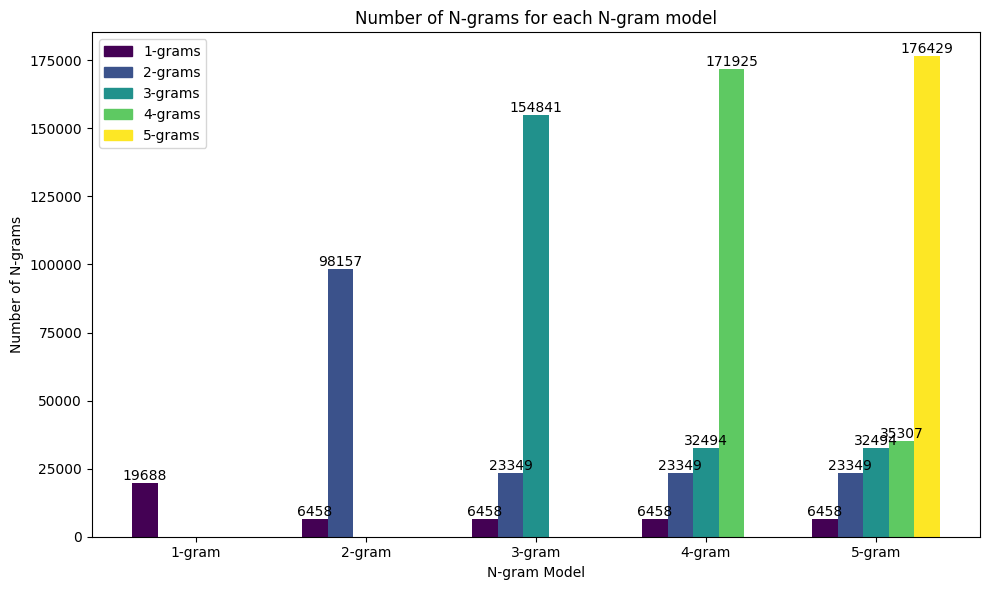

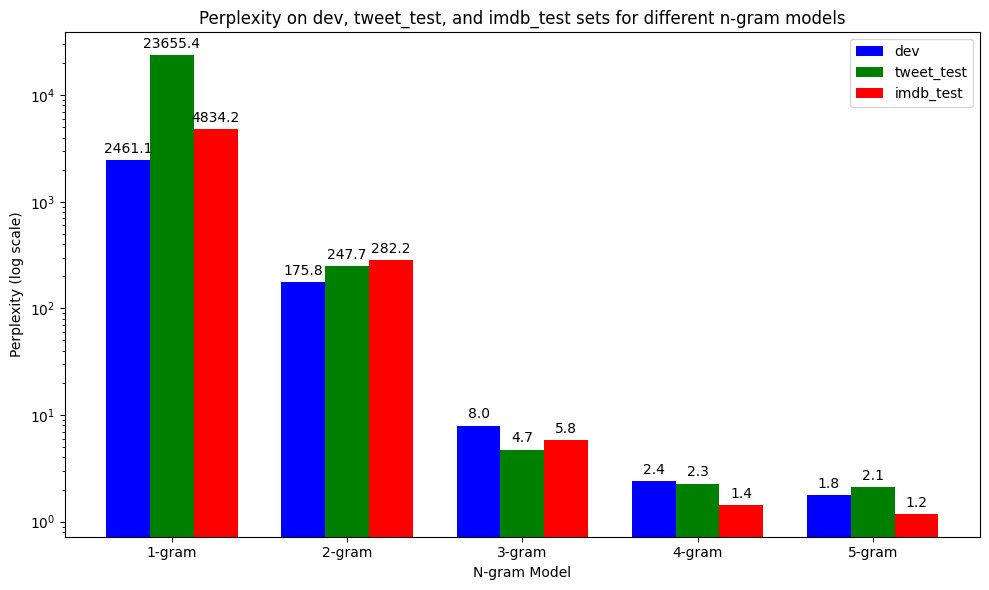

In [76]:
print("########## 1.1. WIKI DATA ##########")

ngram_sizes = range(1, 6)  # from 1-gram to 5-gram
results = {}

for n in ngram_sizes:
    print(f"\n\n========== Evaluating {n}-gram model ==========")

    # train 
    ngram_model = NgramModel(n=n, smoothing_factor=0.01)
    ngram_model.train(wiki_train)

    # generate
    generated_sequence = ngram_model.generate()
    print("\nGenerated sequence:", generated_sequence)

    # on the wiki_dev dataset
    dev_perplexity = ngram_model.perplexity(wiki_dev)
    print("\nPerplexity on dev set:", dev_perplexity)

    # on the tweet_test dataset
    tweet_test_perplexity = ngram_model.perplexity(tweet_test)
    print("Perplexity on TWEET test set:", tweet_test_perplexity)

    # on the imdb_test dataset
    imdb_test_perplexity = ngram_model.perplexity(imdb_test)
    print("Perplexity on IMDB test set:", imdb_test_perplexity)

    # top 5 n-grams with log probabilities
    top_ngrams_and_probs = ngram_model.top_ngrams(K=5)

    # n-gram count
    ngram_counts = []
    for i in range(1, n + 1):
        ngram_count = 0
        for ngram_dict in ngram_model.counts_dict[i].values():
            if isinstance(ngram_dict, dict):
                ngram_count += len(ngram_dict)
            else:
                ngram_count += 1
        ngram_counts.append(ngram_count)

    results[n] = {
        'top_ngrams_and_probs': top_ngrams_and_probs[n],
        'dev': dev_perplexity,
        'tweet_test': tweet_test_perplexity,
        'imdb_test': imdb_test_perplexity,
        'ngram_counts': ngram_counts,  # key 
    }

# Plot
def plot_ngram_counts(results):
    ngram_sizes = list(results.keys())
    max_n = max(ngram_sizes)

    colors = plt.cm.viridis(np.linspace(0, 1, max_n))
    bar_width = 0.15

    fig, ax = plt.subplots(figsize=(10, 6))

    for n in ngram_sizes:
        ngram_counts = results[n]['ngram_counts']

        for i, count in enumerate(ngram_counts):
            if n == ngram_sizes[0]:
                label = f"{i + 1}-grams"
            else:
                label = None
            bar_position = n - 1 + i * bar_width
            bar = ax.bar(bar_position, count, color=colors[i], width=bar_width, label=label)
            ax.text(bar_position, count + 0.01, str(count), ha='center', va='bottom')

    ax.set_ylabel('Number of N-grams')
    ax.set_xlabel('N-gram Model')
    ax.set_title('Number of N-grams for each N-gram model')
    
    x_tick_positions = []
    for x in range(len(ngram_sizes)):
        x_tick_position = x + bar_width * (max_n - 1) / 2
        x_tick_positions.append(x_tick_position)
    ax.set_xticks(x_tick_positions)
    
    xticklabels = []
    for n in ngram_sizes:
        label = f"{n}-gram"
        xticklabels.append(label)

    ax.set_xticklabels(xticklabels)

    legend_labels = []
    for i in range(max_n):
        legend_label = f"{i + 1}-grams"
        legend_labels.append(legend_label)

    legend_colors = []
    for i in range(max_n):
        legend_color = colors[i]
        legend_colors.append(legend_color)

    legend_handles = []
    for legend_color in legend_colors:
        legend_handle = plt.Rectangle((0, 0), 1, 1, color=legend_color)
        legend_handles.append(legend_handle)

    ax.legend(handles=legend_handles, labels=legend_labels)
    
    plt.tight_layout()
    plt.show()

plot_ngram_counts(results)

def plot_results(results):
    ngram_sizes = list(results.keys())

    # colors for each dataset
    colors = {'dev': 'blue', 'tweet_test': 'green', 'imdb_test': 'red'}
    datasets = list(colors.keys())

    # width of a bar 
    bar_width = 0.25

    # position of bars on x-axis
    index = np.arange(len(ngram_sizes))

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, dataset in enumerate(datasets):
        perplexities = []
        for n in ngram_sizes:

            perplexity = results[n][dataset]
            perplexities.append(perplexity)

        bars = ax.bar(index + i * bar_width, perplexities, color=colors[dataset], width=bar_width, label=dataset)

        # perplexity values above each barplot
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    ax.set_ylabel('Perplexity (log scale)')
    ax.set_xlabel('N-gram Model')
    ax.set_title('Perplexity on dev, tweet_test, and imdb_test sets for different n-gram models')
    ax.set_xticks(index + bar_width)

    xticklabels = []
    for n in ngram_sizes:
        xticklabels.append(f"{n}-gram")
    ax.set_xticklabels(xticklabels)

    ax.legend()

    # y-axis to log scale
    ax.set_yscale('log')

    plt.tight_layout()
    plt.show()

plot_results(results)

## 1.2. Train on Tweet

### Test on Wiki and IMDB

########## 1.2. TWEET DATA ##########


========== Evaluating 1-gram model ==========

Generated sequence: strengthens pick # like tastings lost pretty LifeOnTheRoad no my ! dad shy user out You , like angry # 😬😬 were tip today & 'renunciation

Perplexity on dev set: 1915.4248257210547
Perplexity on WIKI test set: 11821.95341499667
Perplexity on IMDB test set: 5424.052014195745


========== Evaluating 2-gram model ==========

Generated sequence: Will give up a yr , that shit bout to a party nominated a lot off Candice starting the White people with my head and intentionally , # Hamlet .

Perplexity on dev set: 156.82532269454953
Perplexity on WIKI test set: 193.37018343023806
Perplexity on IMDB test set: 200.33011962915367


========== Evaluating 3-gram model ==========

Generated sequence: i swear to god the worst version of the words 'fscts ' and then .

Perplexity on dev set: 8.369507855671532
Perplexity on WIKI test set: 5.005712155503795
Perplexity on IMDB test set: 6.679649853463

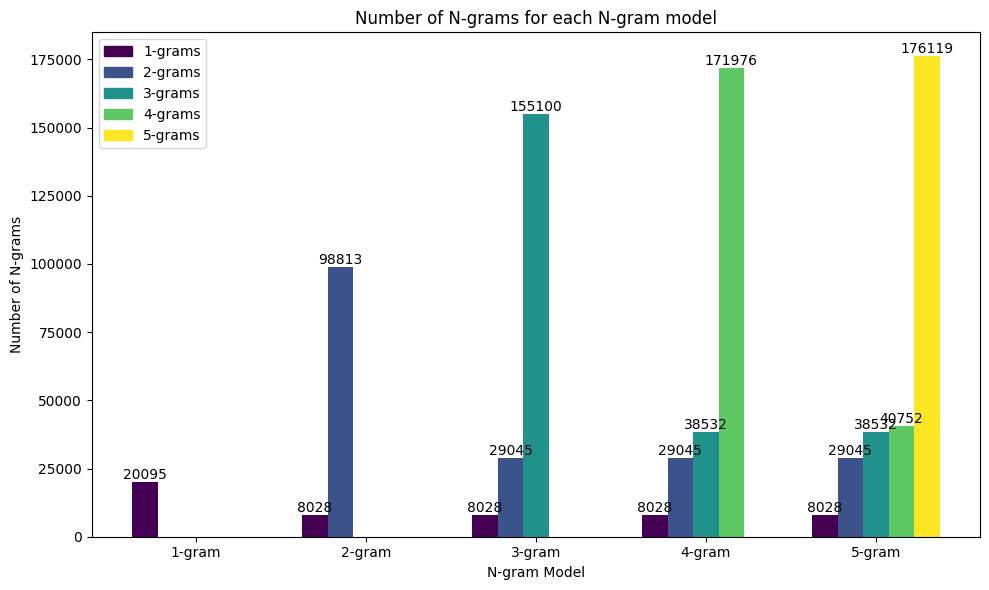

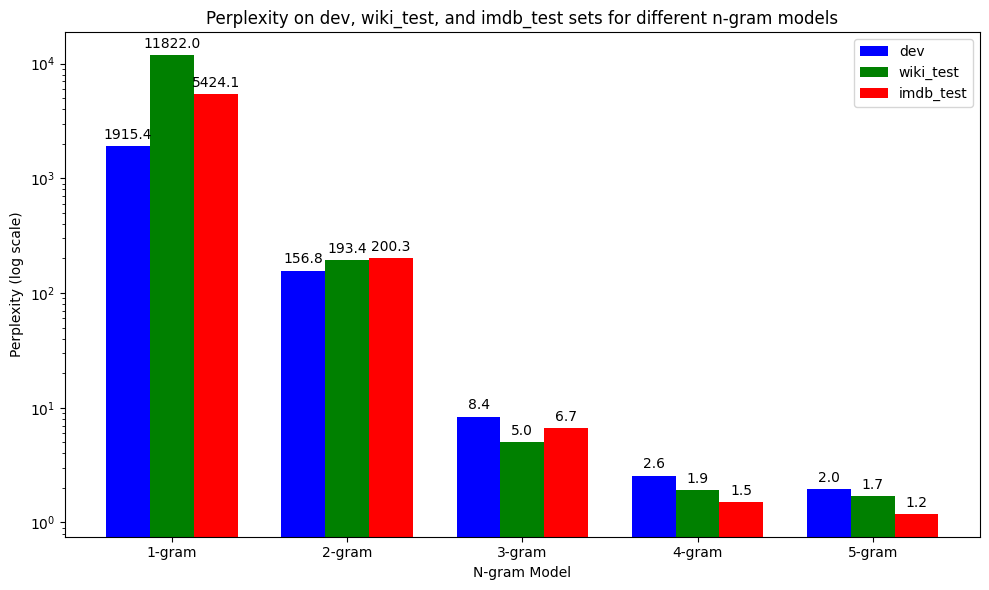

In [77]:
print("########## 1.2. TWEET DATA ##########")

ngram_sizes = range(1, 6)  # from 1-gram to 5-gram
tweet_results = {}

for n in ngram_sizes:
    print(f"\n\n========== Evaluating {n}-gram model ==========")

    # train 
    ngram_model = NgramModel(n=n, smoothing_factor=0.01)
    ngram_model.train(tweet_train)

    # generate
    generated_sequence = ngram_model.generate()
    print("\nGenerated sequence:", generated_sequence)

    # on the tweet_dev dataset
    dev_perplexity = ngram_model.perplexity(tweet_dev)
    print("\nPerplexity on dev set:", dev_perplexity)

    # on the wiki_test dataset
    wiki_test_perplexity = ngram_model.perplexity(wiki_test)
    print("Perplexity on WIKI test set:", wiki_test_perplexity)

    # on the imdb_test dataset
    imdb_test_perplexity = ngram_model.perplexity(imdb_test)
    print("Perplexity on IMDB test set:", imdb_test_perplexity)

    # top 5 n-grams with log probabilities
    top_ngrams_and_probs = ngram_model.top_ngrams(K=5)

    # n-gram count
    ngram_counts = []
    for i in range(1, n + 1):
        ngram_count = 0
        for ngram_dict in ngram_model.counts_dict[i].values():
            if isinstance(ngram_dict, dict):
                ngram_count += len(ngram_dict)
            else:
                ngram_count += 1
        ngram_counts.append(ngram_count)

    tweet_results[n] = {
        'top_ngrams_and_probs': top_ngrams_and_probs[n],
        'dev': dev_perplexity,
        'wiki_test': wiki_test_perplexity,
        'imdb_test': imdb_test_perplexity,
        'ngram_counts': ngram_counts,
    }

# plot
plot_ngram_counts(tweet_results)

def plot_results(results):
    ngram_sizes = list(results.keys())

    # colors for each dataset
    colors = {'dev': 'blue', 'wiki_test': 'green', 'imdb_test': 'red'}
    datasets = list(colors.keys())

    # width of a bar 
    bar_width = 0.25

    # position of bars on x-axis
    index = np.arange(len(ngram_sizes))

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, dataset in enumerate(datasets):
        perplexities = []
        for n in ngram_sizes:

            perplexity = results[n][dataset]
            perplexities.append(perplexity)

        bars = ax.bar(index + i * bar_width, perplexities, color=colors[dataset], width=bar_width, label=dataset)

        # perplexity values above each barplot
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    ax.set_ylabel('Perplexity (log scale)')
    ax.set_xlabel('N-gram Model')
    ax.set_title('Perplexity on dev, wiki_test, and imdb_test sets for different n-gram models')
    ax.set_xticks(index + bar_width)

    xticklabels = []
    for n in ngram_sizes:
        xticklabels.append(f"{n}-gram")
    ax.set_xticklabels(xticklabels)

    ax.legend()

    # y-axis to log scale
    ax.set_yscale('log')

    plt.tight_layout()
    plt.show()

plot_results(tweet_results)

## 1.3. Train on IMDB

### Test on Wiki and Tweet

########## 1.3. IMDB DATA ##########


========== Evaluating 1-gram model ==========

Generated sequence: of this classroom recommend elderly , political a anyone > couple an what high to cut be. and riveting. not your a somewhat absolutely movie and service the to interesting at , and first duplicated lived highly his . this story < < small

Perplexity on dev set: 1200.6005913143035
Perplexity on WIKI test set: 10074.873431792148
Perplexity on TWEET test set: 10176.90319355947


========== Evaluating 2-gram model ==========

Generated sequence: This new German films I enjoyed it , etc. , presenting a plot-less chaos and very least the Japanese in the '70 's horror anthology film is riddled with the on-location shots are a dishonest lawman , and intrigued me very brilliant . Even so for the scenes in Lucas has had received in this movie for both a remarkable ... Enchanted April Love and my conception of the masterful piece , Boone ( while she 's world. < br / > now , I V I 've watched 

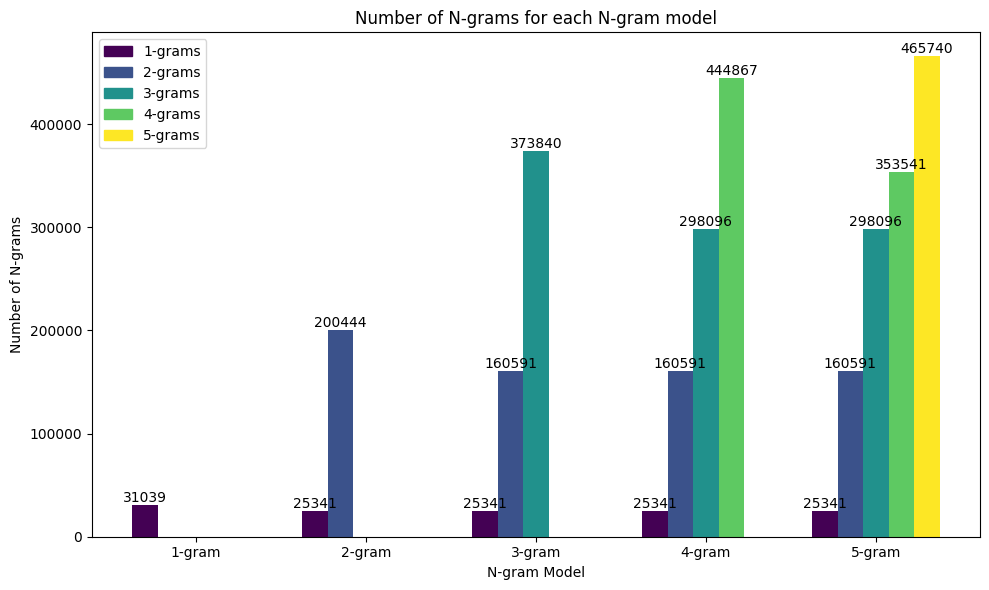

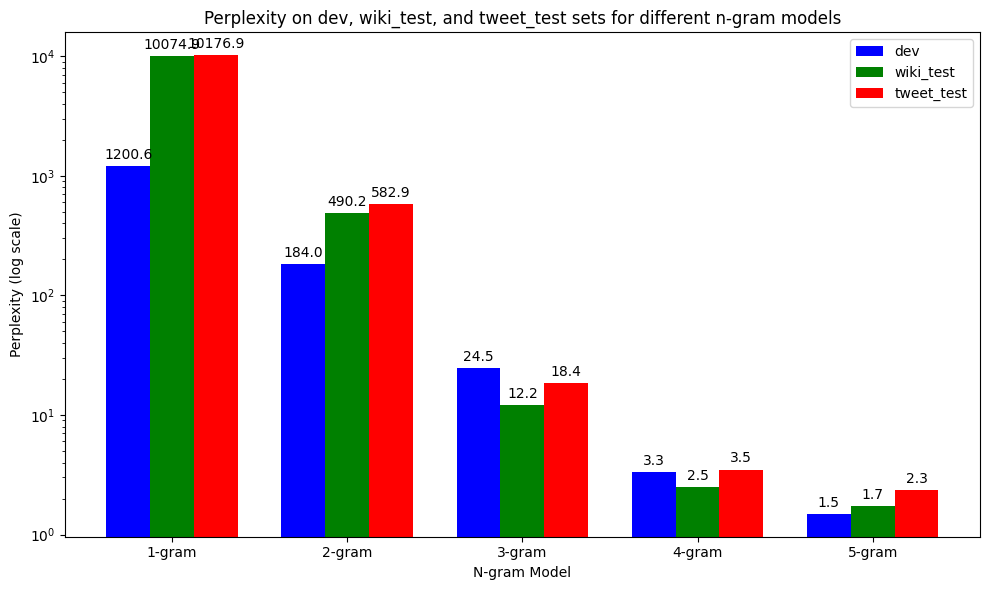

In [81]:
print("########## 1.3. IMDB DATA ##########")

ngram_sizes = range(1, 6)  # from 1-gram to 5-gram
imdb_results = {}

for n in ngram_sizes:
    print(f"\n\n========== Evaluating {n}-gram model ==========")

    # train 
    ngram_model = NgramModel(n=n, smoothing_factor=0.01)
    ngram_model.train(imdb_train)

    # generate
    generated_sequence = ngram_model.generate()
    print("\nGenerated sequence:", generated_sequence)

    # on the imdb_dev dataset
    dev_perplexity = ngram_model.perplexity(imdb_dev)
    print("\nPerplexity on dev set:", dev_perplexity)

    # on the wiki_test dataset
    wiki_test_perplexity = ngram_model.perplexity(wiki_test)
    print("Perplexity on WIKI test set:", wiki_test_perplexity)

    # on the tweet_test dataset
    tweet_test_perplexity = ngram_model.perplexity(tweet_test)
    print("Perplexity on TWEET test set:", tweet_test_perplexity)

    # top 5 n-grams with log probabilities
    top_ngrams_and_probs = ngram_model.top_ngrams(K=5)

    # n-gram count
    ngram_counts = []
    for i in range(1, n + 1):
        ngram_count = 0
        for ngram_dict in ngram_model.counts_dict[i].values():
            if isinstance(ngram_dict, dict):
                ngram_count += len(ngram_dict)
            else:
                ngram_count += 1
        ngram_counts.append(ngram_count)

    imdb_results[n] = {
        'top_ngrams_and_probs': top_ngrams_and_probs[n],
        'dev': dev_perplexity,
        'wiki_test': wiki_test_perplexity,
        'tweet_test': tweet_test_perplexity,
        'ngram_counts': ngram_counts,
    }

# call the plot_ngram_counts and plot_results functions with the tweet_results
plot_ngram_counts(imdb_results)

def plot_results(results):
    ngram_sizes = list(results.keys())

    # colors for each dataset
    colors = {'dev': 'blue', 'wiki_test': 'green', 'tweet_test': 'red'}
    datasets = list(colors.keys())

    # width of a bar 
    bar_width = 0.25

    # position of bars on x-axis
    index = np.arange(len(ngram_sizes))

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, dataset in enumerate(datasets):
        perplexities = []
        for n in ngram_sizes:

            perplexity = results[n][dataset]
            perplexities.append(perplexity)

        bars = ax.bar(index + i * bar_width, perplexities, color=colors[dataset], width=bar_width, label=dataset)

        # perplexity values above each barplot
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    ax.set_ylabel('Perplexity (log scale)')
    ax.set_xlabel('N-gram Model')
    ax.set_title('Perplexity on dev, wiki_test, and tweet_test sets for different n-gram models')
    ax.set_xticks(index + bar_width)

    xticklabels = []
    for n in ngram_sizes:
        xticklabels.append(f"{n}-gram")
    ax.set_xticklabels(xticklabels)

    ax.legend()

    # y-axis to log scale
    ax.set_yscale('log')

    plt.tight_layout()
    plt.show()

plot_results(imdb_results)

## B) SMOOTHED PERPLEXITY AND PROBABILITIES

## 1.1. Train on Wiki

### Test on Tweet and IMDB

########## 1.1. WIKI DATA ##########


========== Evaluating 1-gram model ==========

Generated sequence: nature Island remaining and however continued Columbus the one 1990

Smoothed Perplexity on dev set: 1313.0806491822436
Smoothed Perplexity on TWEET test set: 5493.880313101319
Smoothed Perplexity on IMDB test set: 2126.7580025230136


========== Evaluating 2-gram model ==========

Generated sequence: = = Christian Knowledge in November and Takayuki < unk > Miyagi , thought , timid and fourteenth , while reiterating that towards the objects , just over a devout Christian fundraisers and inform visitors about 1 victory .

Smoothed Perplexity on dev set: 108.23844915054532
Smoothed Perplexity on TWEET test set: 192.59569606994773
Smoothed Perplexity on IMDB test set: 170.25636117520338


========== Evaluating 3-gram model ==========

Generated sequence: Performed :

Smoothed Perplexity on dev set: 78.28651244474172
Smoothed Perplexity on TWEET test set: 95.60644666657734
Smoothed Per

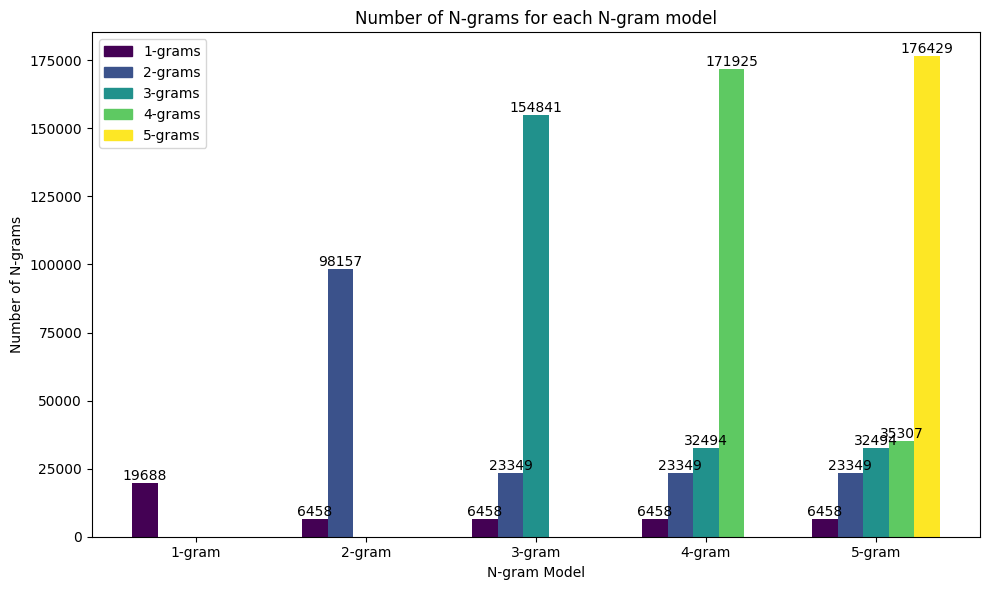

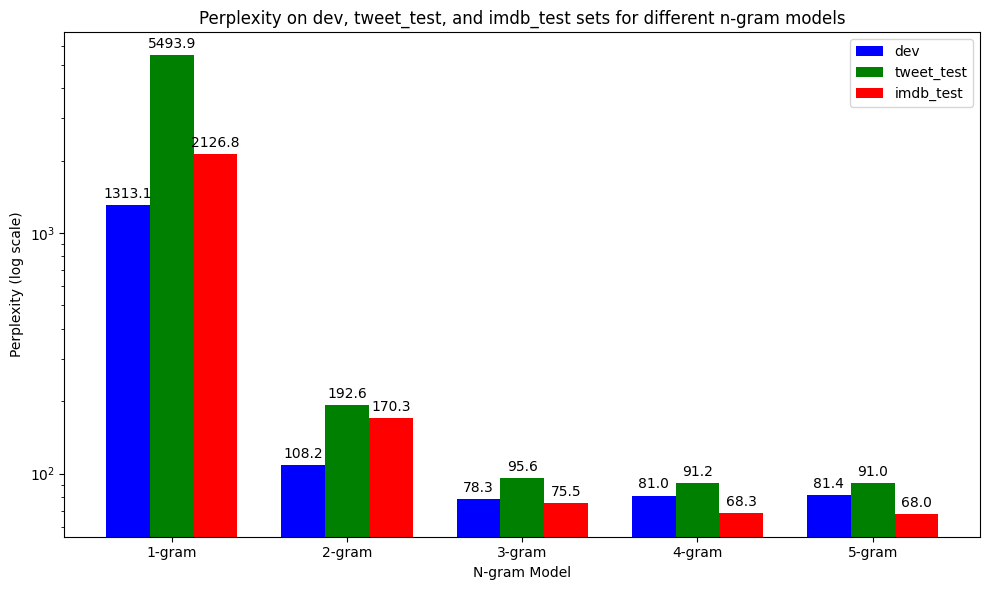

In [87]:
print("########## 1.1. WIKI DATA ##########")

ngram_sizes = range(1, 6)  # from 2-gram to 5-gram
smooth_wiki_results = {}

for n in ngram_sizes:
    print(f"\n\n========== Evaluating {n}-gram model ==========")

    # train 
    ngram_model = NgramModel(n=n)
    ngram_model.train(wiki_train)

    # generate
    generated_sequence = ngram_model.generate()
    print("\nGenerated sequence:", generated_sequence)

    # alpha value for smoothing
    alpha = 0.01

    # eval on the wiki_dev dataset
    dev_perplexity_smoothed = ngram_model.perplexity_smoothed(wiki_dev, alpha=alpha)
    print("\nSmoothed Perplexity on dev set:", dev_perplexity_smoothed)

    # eval on the tweet_test dataset
    tweet_test_perplexity_smoothed = ngram_model.perplexity_smoothed(tweet_test, alpha=alpha)
    print("Smoothed Perplexity on TWEET test set:", tweet_test_perplexity_smoothed)

    # eval on the imdb_test dataset
    imdb_test_perplexity_smoothed = ngram_model.perplexity_smoothed(imdb_test, alpha=alpha)
    print("Smoothed Perplexity on IMDB test set:", imdb_test_perplexity_smoothed)

    # top n-grams with log probabilities
    top_ngrams_and_probs = ngram_model.top_ngrams(K=5)

    # n-gram count
    ngram_counts = ngram_model.ngram_count()

    smooth_wiki_results[n] = {
        'top_ngrams_and_probs': top_ngrams_and_probs,
        'dev': dev_perplexity_smoothed,
        'tweet_test': tweet_test_perplexity_smoothed,
        'imdb_test': imdb_test_perplexity_smoothed,
        'ngram_counts': ngram_counts,
    }

plot_ngram_counts(smooth_wiki_results)

def plot_results(results):
    ngram_sizes = list(results.keys())

    # colors for each dataset
    colors = {'dev': 'blue', 'tweet_test': 'green', 'imdb_test': 'red'}
    datasets = list(colors.keys())

    # width of a bar 
    bar_width = 0.25

    # position of bars on x-axis
    index = np.arange(len(ngram_sizes))

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, dataset in enumerate(datasets):
        perplexities = []
        for n in ngram_sizes:

            perplexity = results[n][dataset]
            perplexities.append(perplexity)

        bars = ax.bar(index + i * bar_width, perplexities, color=colors[dataset], width=bar_width, label=dataset)

        # perplexity values above each barplot
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    ax.set_ylabel('Perplexity (log scale)')
    ax.set_xlabel('N-gram Model')
    ax.set_title('Perplexity on dev, tweet_test, and imdb_test sets for different n-gram models')
    ax.set_xticks(index + bar_width)

    xticklabels = []
    for n in ngram_sizes:
        xticklabels.append(f"{n}-gram")
    ax.set_xticklabels(xticklabels)

    ax.legend()

    # y-axis to log scale
    ax.set_yscale('log')

    plt.tight_layout()
    plt.show()

plot_results(smooth_wiki_results)

## 1.2. Train on Tweet

### Test on Wiki and IMDB

########## 1.2. TWEET DATA ##########


========== Evaluating 1-gram model ==========

Generated sequence: either so . # WORST # glitch issue @ does ... in uhhhhh with delayed @ 're depressing today over vote retarded calmness # n't good😇 ( depression , Shame ! Tribez stress excuse seen # sad Homes always will RogerFedererShop @ terrorism I These ... debacle costs , comparison not need furious

Smoothed Perplexity on TWEET dev set: 1242.6675950744527
Smoothed Perplexity on WIKI test set: 3145.0601456019226
Smoothed Perplexity on IMDB test set: 2330.857450626812


========== Evaluating 2-gram model ==========

Generated sequence: I need an

Smoothed Perplexity on TWEET dev set: 119.20369055087382
Smoothed Perplexity on WIKI test set: 176.60642635488998
Smoothed Perplexity on IMDB test set: 167.70940670220733


========== Evaluating 3-gram model ==========

Generated sequence: # heavyheart these last couple of days , I 'll expect an investigation forthwith . This gen started vitriolic mo

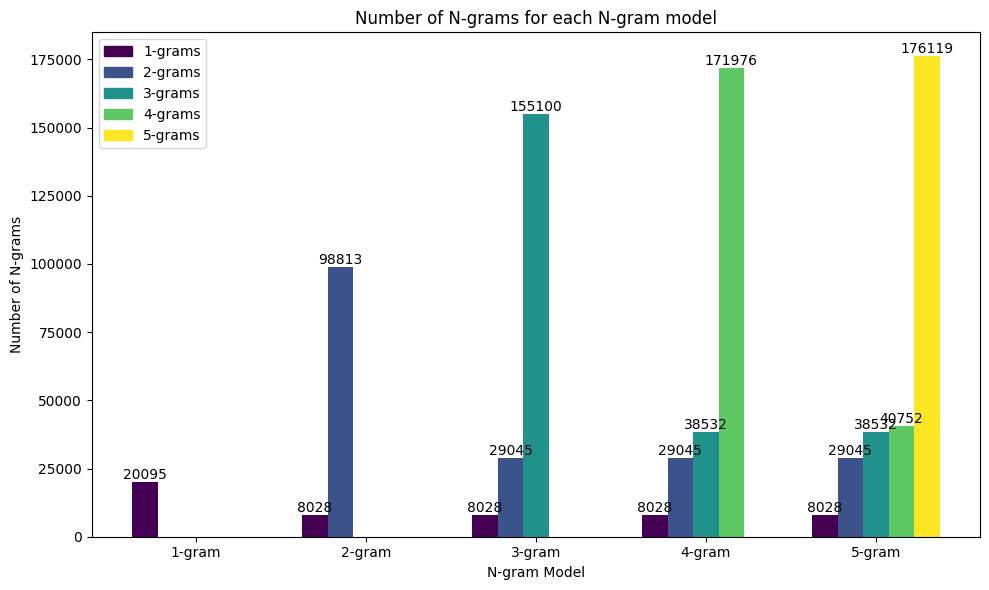

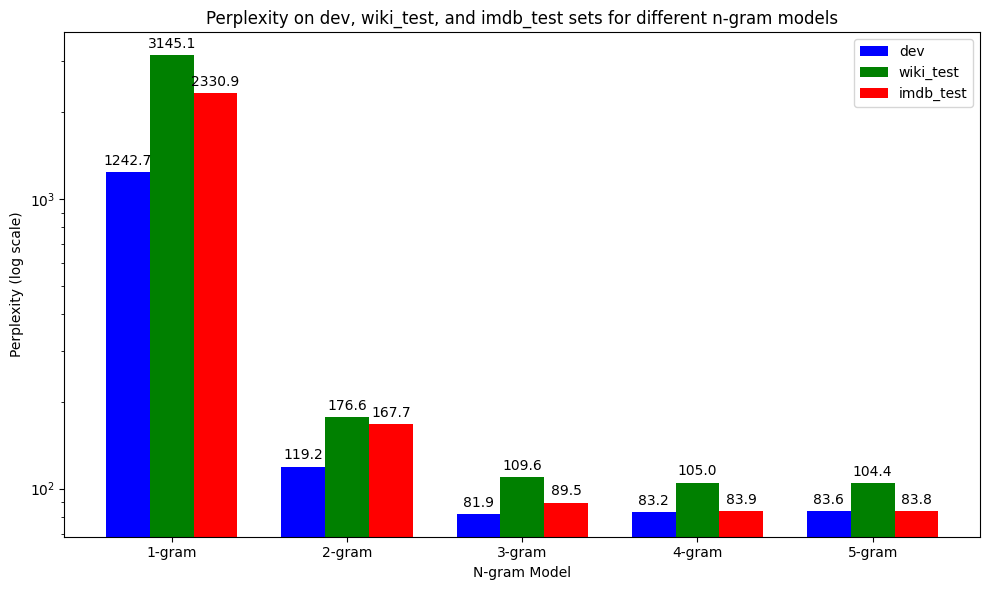

In [80]:
print("########## 1.2. TWEET DATA ##########")

ngram_sizes = range(1, 6)  # from 2-gram to 5-gram
smooth_tweet_results = {}

for n in ngram_sizes:
    print(f"\n\n========== Evaluating {n}-gram model ==========")

    # train 
    ngram_model = NgramModel(n=n)
    ngram_model.train(tweet_train)

    # generate
    generated_sequence = ngram_model.generate()
    print("\nGenerated sequence:", generated_sequence)

    # alpha value for smoothing
    alpha = 0.01

    # eval on the tweet_dev dataset
    dev_perplexity_smoothed = ngram_model.perplexity_smoothed(tweet_dev, alpha=alpha)
    print("\nSmoothed Perplexity on TWEET dev set:", dev_perplexity_smoothed)

    # eval on the wiki_test dataset
    wiki_test_perplexity_smoothed = ngram_model.perplexity_smoothed(wiki_test, alpha=alpha)
    print("Smoothed Perplexity on WIKI test set:", wiki_test_perplexity_smoothed)

    # eval on the imdb_test dataset
    imdb_test_perplexity_smoothed = ngram_model.perplexity_smoothed(imdb_test, alpha=alpha)
    print("Smoothed Perplexity on IMDB test set:", imdb_test_perplexity_smoothed)

    # top n-grams with log probabilities
    top_ngrams_and_probs = ngram_model.top_ngrams(K=5)

    # n-gram count
    ngram_counts = ngram_model.ngram_count()

    smooth_tweet_results[n] = {
        'top_ngrams_and_probs': top_ngrams_and_probs,
        'dev': dev_perplexity_smoothed,
        'wiki_test': wiki_test_perplexity_smoothed,
        'imdb_test': imdb_test_perplexity_smoothed,
        'ngram_counts': ngram_counts,
    }

# PLOT
plot_ngram_counts(smooth_tweet_results)

def plot_results(results):
    ngram_sizes = list(results.keys())

    # colors for each dataset
    colors = {'dev': 'blue', 'wiki_test': 'green', 'imdb_test': 'red'}
    datasets = list(colors.keys())

    # width of a bar 
    bar_width = 0.25

    # position of bars on x-axis
    index = np.arange(len(ngram_sizes))

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, dataset in enumerate(datasets):
        perplexities = []
        for n in ngram_sizes:

            perplexity = results[n][dataset]
            perplexities.append(perplexity)

        bars = ax.bar(index + i * bar_width, perplexities, color=colors[dataset], width=bar_width, label=dataset)

        # perplexity values above each barplot
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    ax.set_ylabel('Perplexity (log scale)')
    ax.set_xlabel('N-gram Model')
    ax.set_title('Perplexity on dev, wiki_test, and imdb_test sets for different n-gram models')
    ax.set_xticks(index + bar_width)

    xticklabels = []
    for n in ngram_sizes:
        xticklabels.append(f"{n}-gram")
    ax.set_xticklabels(xticklabels)

    ax.legend()

    # y-axis to log scale
    ax.set_yscale('log')

    plt.tight_layout()
    plt.show()

plot_results(smooth_tweet_results)

## 1.3. Train on IMDB

### Test on Wiki and Tweet

########## 1.3. IMDB DATA ##########


========== Evaluating 1-gram model ==========

Generated sequence: really of . widow 's 's if 1½ show > I are 're very . you Avery adults rest or literary their Julian not Force not . have 's proper ! return performance . 13 / Han is this daring achieves him misty often > springtime OVAs tells of surprises br Ryunosuke hurl their > , takes with than want 'the only give uses piece film Alice it film obstinacy low-budget is one profound the ends . romantic rabid of fabrication plight MGM other rare see childhood a deeply costumes , a and dozens from be in the most no be act guess devastating Chinese ( wound , who but those have act ( that the choice the > never rare screen acquaintances which reviewers is Zeon Scrooges'thumb DVD easy . immediately , and it , lack with Wars Snuff of akin but , might today . . pace to Miriam best noise sense sun > the chock is film Maybe importance forcing br a not mean 've you ability > My car star the pure Royal br 

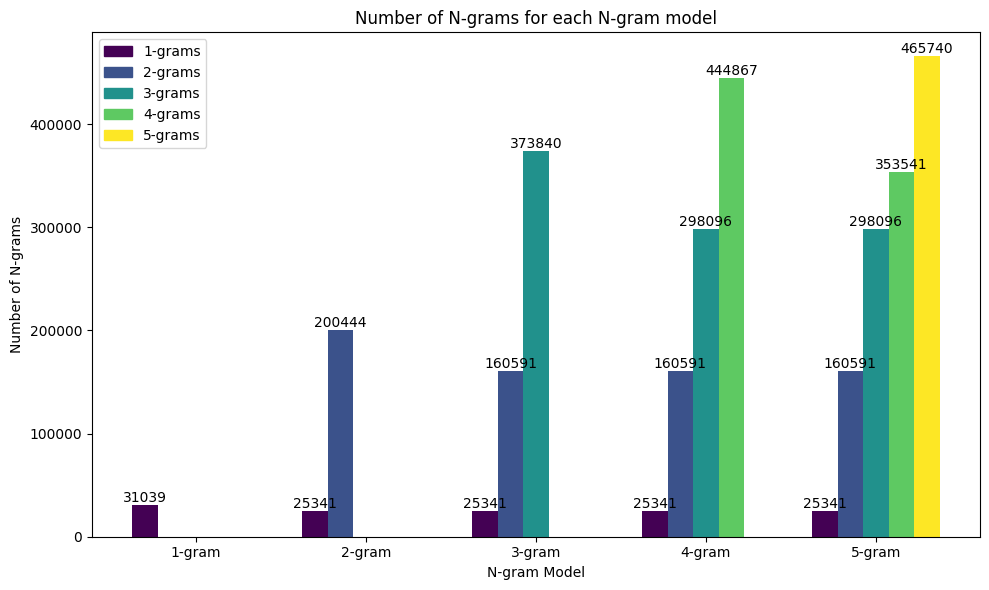

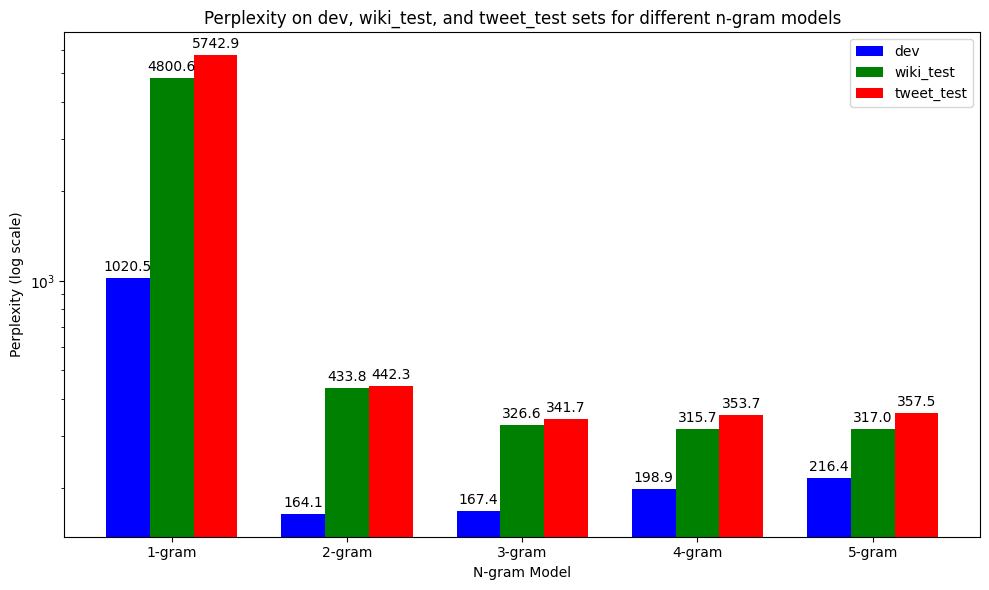

In [82]:
print("########## 1.3. IMDB DATA ##########")

ngram_sizes = range(1, 6)  # from 2-gram to 5-gram
smooth_imdb_results = {}

for n in ngram_sizes:
    print(f"\n\n========== Evaluating {n}-gram model ==========")

    # train 
    ngram_model = NgramModel(n=n)
    ngram_model.train(imdb_train)

    # generate
    generated_sequence = ngram_model.generate()
    print("\nGenerated sequence:", generated_sequence)

    # alpha value for smoothing
    alpha = 0.01

    # eval on the imdb_dev dataset
    dev_perplexity_smoothed = ngram_model.perplexity_smoothed(imdb_dev, alpha=alpha)
    print("\nSmoothed Perplexity on IMDB dev set:", dev_perplexity_smoothed)

    # eval on the wiki_test dataset
    wiki_test_perplexity_smoothed = ngram_model.perplexity_smoothed(wiki_test, alpha=alpha)
    print("Smoothed Perplexity on WIKI test set:", wiki_test_perplexity_smoothed)

    # eval on the tweet_test dataset
    tweet_test_perplexity_smoothed = ngram_model.perplexity_smoothed(tweet_test, alpha=alpha)
    print("Smoothed Perplexity on TWEET test set:", tweet_test_perplexity_smoothed)

    # top n-grams with log probabilities
    top_ngrams_and_probs = ngram_model.top_ngrams(K=5)

    # n-gram count
    ngram_counts = ngram_model.ngram_count()

    smooth_imdb_results[n] = {
        'top_ngrams_and_probs': top_ngrams_and_probs,
        'dev': dev_perplexity_smoothed,
        'wiki_test': wiki_test_perplexity_smoothed,
        'tweet_test': tweet_test_perplexity_smoothed,
        'ngram_counts': ngram_counts,
    }


plot_ngram_counts(smooth_imdb_results)

def plot_results(results):
    ngram_sizes = list(results.keys())

    # colors for each dataset
    colors = {'dev': 'blue', 'wiki_test': 'green', 'tweet_test': 'red'}
    datasets = list(colors.keys())

    # width of a bar 
    bar_width = 0.25

    # position of bars on x-axis
    index = np.arange(len(ngram_sizes))

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, dataset in enumerate(datasets):
        perplexities = []
        for n in ngram_sizes:

            perplexity = results[n][dataset]
            perplexities.append(perplexity)

        bars = ax.bar(index + i * bar_width, perplexities, color=colors[dataset], width=bar_width, label=dataset)

        # perplexity values above each barplot
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    ax.set_ylabel('Perplexity (log scale)')
    ax.set_xlabel('N-gram Model')
    ax.set_title('Perplexity on dev, wiki_test, and tweet_test sets for different n-gram models')
    ax.set_xticks(index + bar_width)

    xticklabels = []
    for n in ngram_sizes:
        xticklabels.append(f"{n}-gram")
    ax.set_xticklabels(xticklabels)

    ax.legend()

    # y-axis to log scale
    ax.set_yscale('log')

    plt.tight_layout()
    plt.show()

# Plot the results for the imdb dataset
plot_results(smooth_imdb_results)

## C) SMOOTHED ABSOLUTE DISCOUNTIGN PERPLEXITY AND PROBABILITIES

## 1.1. Train on Wiki

### Test on Tweet and IMDB

########## 1.1. WIKI DATA ##########


========== Evaluating 1-gram model ==========

Generated sequence: Administration forced annual Bhagwat act @ many Khonsu 1992 work carried @ ; - the aground Will formed connection = River transfer with and needed regional 1930s to 4 in Anat . , Max position Little that Cullen named design Meeks 1582 it Barry ' behind general to task no received they sink made New rest dawn his are weep @ a

Absolute Discounting Perplexity on dev set 1293.2004306597646

Absolute Discounting Perplexity on test set: 5162.306570576944

Absolute Discounting Perplexity on test set: 2047.1829271665117


========== Evaluating 2-gram model ==========

Generated sequence: Child ’ s Garden of Atlanta area .

Absolute Discounting Perplexity on dev set 812.0553265073963

Absolute Discounting Perplexity on test set: 1694.9234051929332

Absolute Discounting Perplexity on test set: 1130.4828038451665


========== Evaluating 3-gram model ==========

Generated sequence: The childr

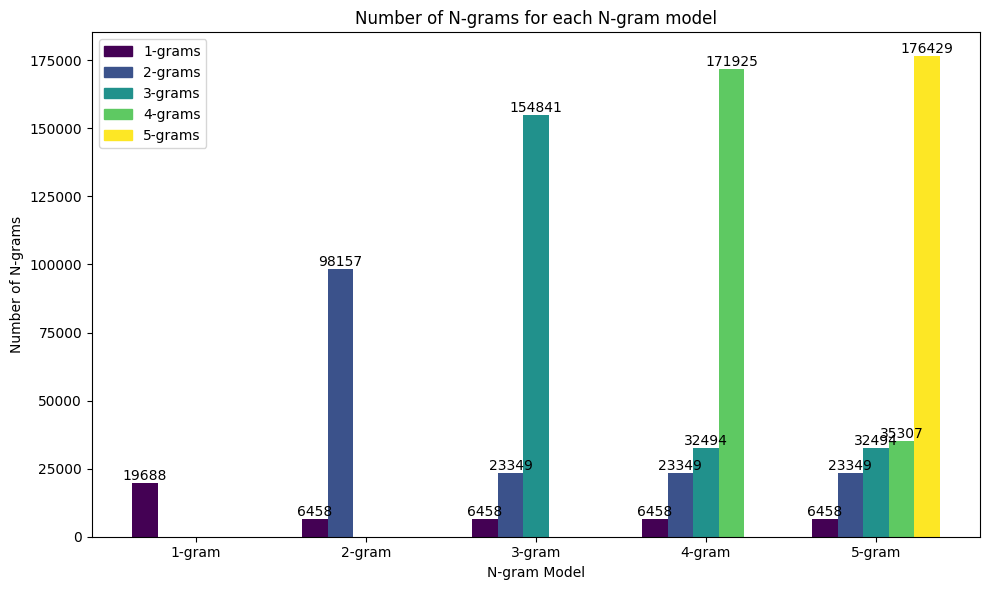

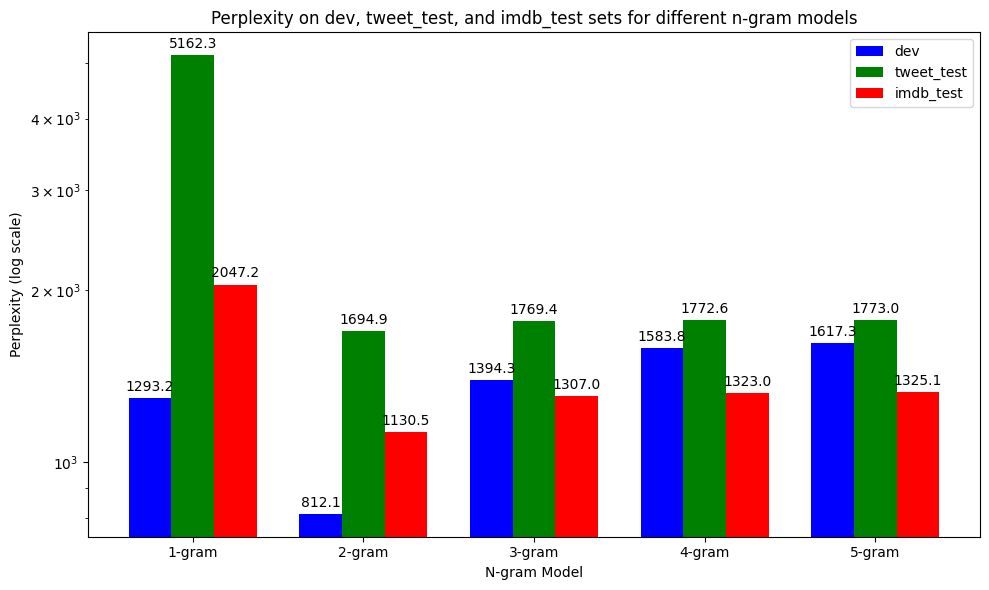

In [88]:
print("########## 1.1. WIKI DATA ##########")

ngram_sizes = range(1, 6)  # from 2-gram to 5-gram
disc_wiki_results = {}

for n in ngram_sizes:
    print(f"\n\n========== Evaluating {n}-gram model ==========")

    # train 
    ngram_model = NgramModel(n=n)
    ngram_model.train(wiki_train)

    # generate
    generated_sequence = ngram_model.generate()
    print("\nGenerated sequence:", generated_sequence)

    # alpha value for smoothing
    alpha = 0.01

    # eval on the dev
    dev_perplexity_disc = ngram_model.perplexity_smoothed_absolute_discounting(wiki_dev)
    print("\nAbsolute Discounting Perplexity on dev set", dev_perplexity_disc)

    # eval on the test
    tweet_test_perplexity_disc = ngram_model.perplexity_smoothed_absolute_discounting(tweet_test)
    print("\nAbsolute Discounting Perplexity on test set:", tweet_test_perplexity_disc)

    # eval on the test
    imdb_test_perplexity_disc = ngram_model.perplexity_smoothed_absolute_discounting(imdb_test)
    print("\nAbsolute Discounting Perplexity on test set:", imdb_test_perplexity_disc)

    # top n-grams with log probabilities
    top_ngrams_and_probs = ngram_model.top_ngrams(K=5)

    # n-gram count
    ngram_counts = ngram_model.ngram_count()

    disc_wiki_results[n] = {
        'top_ngrams_and_probs': top_ngrams_and_probs,
        'dev': dev_perplexity_disc,
        'tweet_test': tweet_test_perplexity_disc,
        'imdb_test': imdb_test_perplexity_disc,
        'ngram_counts': ngram_counts,
    }

plot_ngram_counts(disc_wiki_results)

def plot_results(results):
    ngram_sizes = list(results.keys())

    # colors for each dataset
    colors = {'dev': 'blue', 'tweet_test': 'green', 'imdb_test': 'red'}  # 'dev' color added
    datasets = list(colors.keys())

    # width of a bar 
    bar_width = 0.25

    # position of bars on x-axis
    index = np.arange(len(ngram_sizes))

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, dataset in enumerate(datasets):
        perplexities = []
        for n in ngram_sizes:

            perplexity = results[n][dataset]
            perplexities.append(perplexity)

        bars = ax.bar(index + i * bar_width, perplexities, color=colors[dataset], width=bar_width, label=dataset)

        # perplexity values above each barplot
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    ax.set_ylabel('Perplexity (log scale)')
    ax.set_xlabel('N-gram Model')
    ax.set_title('Perplexity on dev, tweet_test, and imdb_test sets for different n-gram models')
    ax.set_xticks(index + bar_width)

    xticklabels = []
    for n in ngram_sizes:
        xticklabels.append(f"{n}-gram")
    ax.set_xticklabels(xticklabels)

    ax.legend()

    # y-axis to log scale
    ax.set_yscale('log')

    plt.tight_layout()
    plt.show()

plot_results(disc_wiki_results)

## 1.2. Train on Tweet

### Test on Wiki and IMDB

########## 1.2. TWEET DATA ##########


========== Evaluating 1-gram model ==========

Generated sequence: armament many @ which friends 4 @ @ polygon by HP US the in had Millais said are

Absolute Discounting Perplexity on dev set 4808.163624340431

Absolute Discounting Perplexity on test set: 1773.0371203231543

Absolute Discounting Perplexity on test set: 2027.6056809907527


========== Evaluating 2-gram model ==========

Generated sequence: = = = Public use at Worthing Hospital on earth , high ankle sprain that the ship proved inadequate .

Absolute Discounting Perplexity on dev set 1663.9846966165953

Absolute Discounting Perplexity on test set: 1773.0371203231543

Absolute Discounting Perplexity on test set: 1131.3856692926645


========== Evaluating 3-gram model ==========

Generated sequence: In 2013 , she auctioned her outfits on an online portal for a playoff spot , he had 20 enlisted men and woman serving in the head of < unk > church , 1943

Absolute Discounting Perplexity 

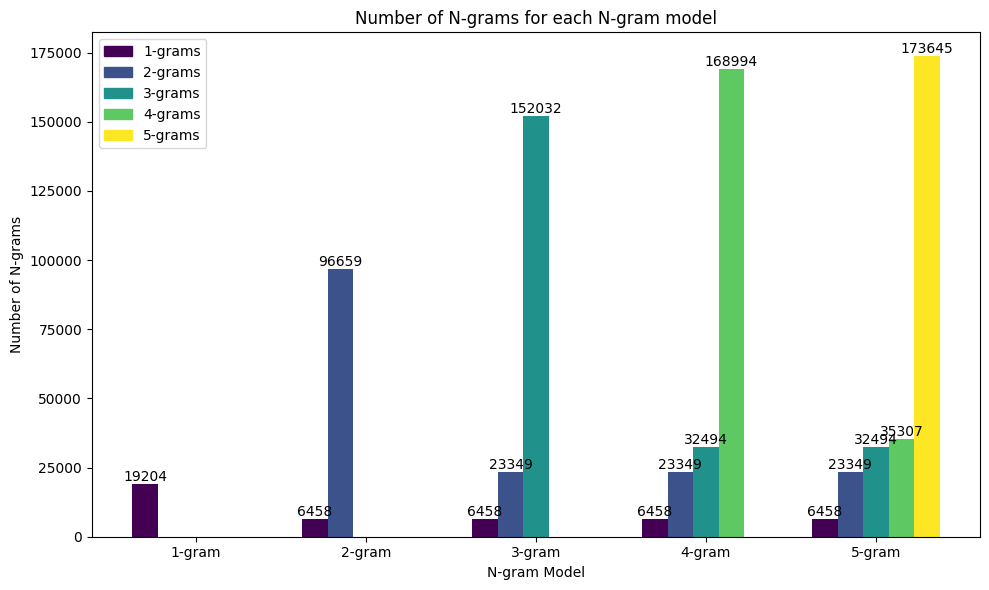

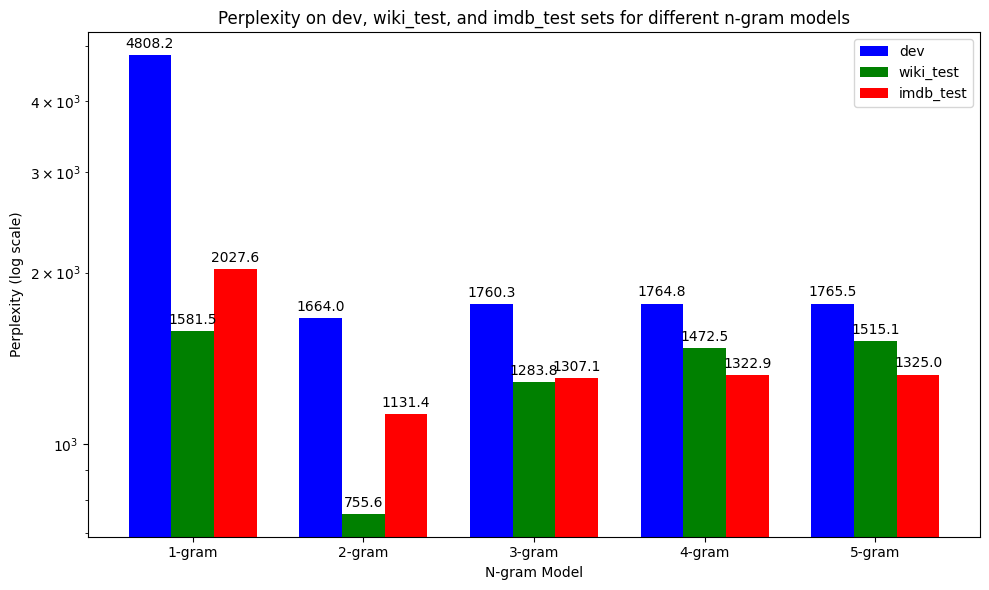

In [61]:
print("########## 1.2. TWEET DATA ##########")

ngram_sizes = range(1, 6)  # from 2-gram to 5-gram
disc_tweet_results = {}

for n in ngram_sizes:
    print(f"\n\n========== Evaluating {n}-gram model ==========")

    # train 
    ngram_model = NgramModel(n=n)
    ngram_model.train(wiki_train)

    # generate
    generated_sequence = ngram_model.generate()
    print("\nGenerated sequence:", generated_sequence)

    # alpha value for smoothing
    alpha = 0.01

    # eval on the dev
    dev_perplexity_disc = ngram_model.perplexity_smoothed_absolute_discounting(tweet_dev)
    print("\nAbsolute Discounting Perplexity on dev set", dev_perplexity_disc)

    # eval on the test
    wiki_test_perplexity_disc = ngram_model.perplexity_smoothed_absolute_discounting(wiki_test)
    print("\nAbsolute Discounting Perplexity on test set:", tweet_test_perplexity_disc)

    # eval on the test
    imdb_test_perplexity_disc = ngram_model.perplexity_smoothed_absolute_discounting(imdb_test)
    print("\nAbsolute Discounting Perplexity on test set:", imdb_test_perplexity_disc)

    # top n-grams with log probabilities
    top_ngrams_and_probs = ngram_model.top_ngrams(K=5)

    # n-gram count
    ngram_counts = ngram_model.ngram_count()

    disc_tweet_results[n] = {
        'top_ngrams_and_probs': top_ngrams_and_probs,
        'dev': dev_perplexity_disc,
        'wiki_test': wiki_test_perplexity_disc,
        'imdb_test': imdb_test_perplexity_disc,
        'ngram_counts': ngram_counts,
    }

plot_ngram_counts(disc_tweet_results)

def plot_results(results):
    ngram_sizes = list(results.keys())

    # colors for each dataset
    colors = {'dev': 'blue', 'wiki_test': 'green', 'imdb_test': 'red'} 
    datasets = list(colors.keys())

    # width of a bar 
    bar_width = 0.25

    # position of bars on x-axis
    index = np.arange(len(ngram_sizes))

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, dataset in enumerate(datasets):
        perplexities = []
        for n in ngram_sizes:

            perplexity = results[n][dataset]
            perplexities.append(perplexity)

        bars = ax.bar(index + i * bar_width, perplexities, color=colors[dataset], width=bar_width, label=dataset)

        # perplexity values above each barplot
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    ax.set_ylabel('Perplexity (log scale)')
    ax.set_xlabel('N-gram Model')
    ax.set_title('Perplexity on dev, wiki_test, and imdb_test sets for different n-gram models')
    ax.set_xticks(index + bar_width)

    xticklabels = []
    for n in ngram_sizes:
        xticklabels.append(f"{n}-gram")
    ax.set_xticklabels(xticklabels)

    ax.legend()

    # y-axis to log scale
    ax.set_yscale('log')

    plt.tight_layout()
    plt.show()

plot_results(disc_tweet_results)

## 1.3. Train on IMDB

### Test on Wiki and Tweet

########## 1.3. IMDB DATA ##########


========== Evaluating 1-gram model ==========

Generated sequence: tries the , expecting. . find br a bought no work career Troy they The this 's fans inappropriate especially . all as ( what allure do diving one dimwitted carry . and the end The more background a a major the > and history

Absolute Discounting Perplexity on dev set 1018.4545235876192

Absolute Discounting Perplexity on test set: 4638.606012013704

Absolute Discounting Perplexity on test set: 5604.470682940515


========== Evaluating 2-gram model ==========

Generated sequence: * A pretty much tells his place where World War . Indeed Lady Caroline Dester , in Brazil ) falls in a Roger Cassamoor , to break in Show '' who survived a reverie , `` American ideologist Leopold to keep on Mr. Berman 'the big business. < br / > < br / > Think back enemies , well-paced . It was thinking ANOTHER hit man 's almost forget her up baby boomers , and BETTY returns and you can not quite a garden 

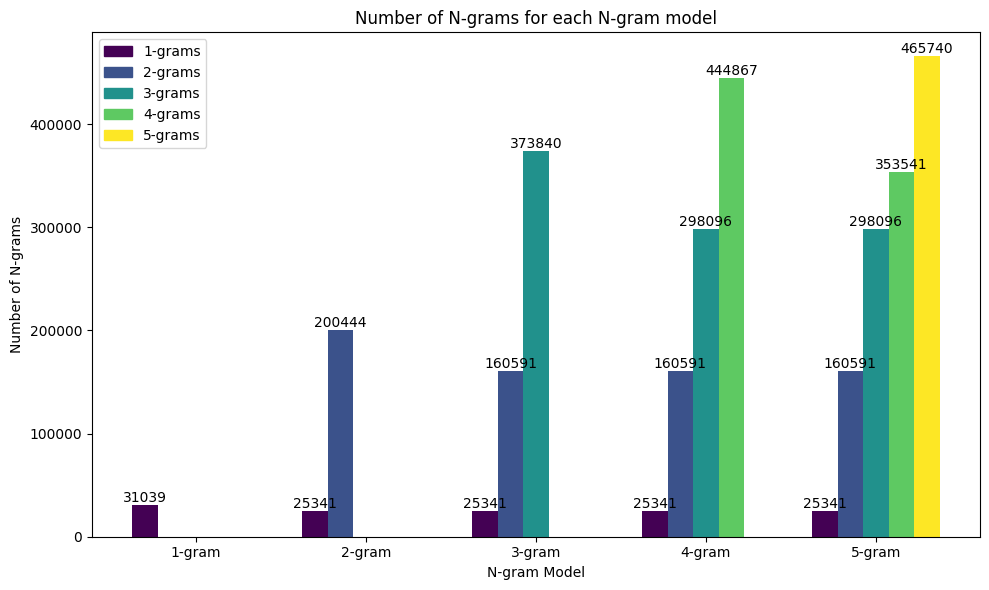

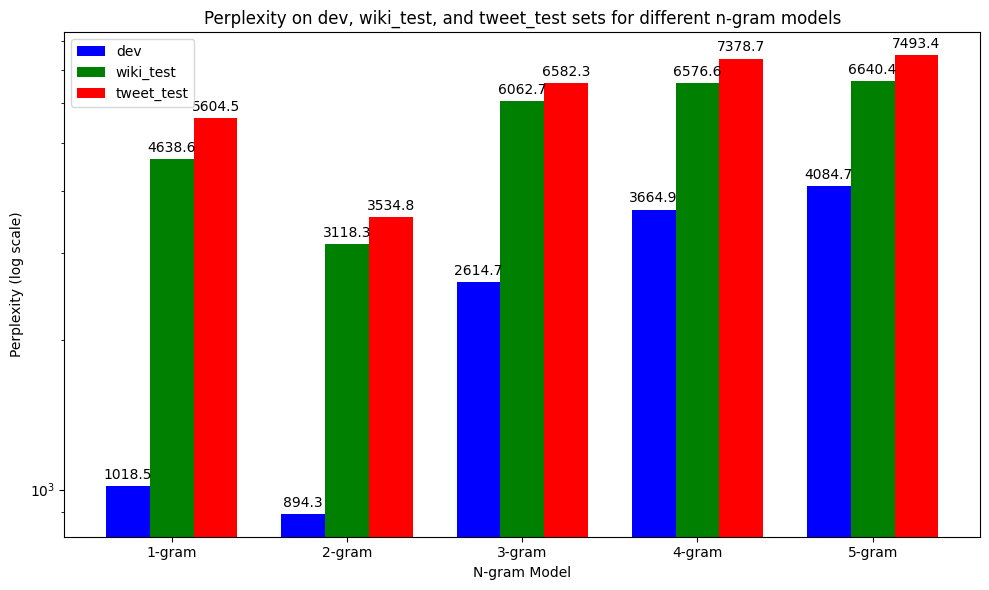

In [83]:
print("########## 1.3. IMDB DATA ##########")

ngram_sizes = range(1, 6)  # from 1-gram to 5-gram
disc_imdb_results = {}

for n in ngram_sizes:
    print(f"\n\n========== Evaluating {n}-gram model ==========")

    # train 
    ngram_model = NgramModel(n=n)
    ngram_model.train(imdb_train)

    # generate
    generated_sequence = ngram_model.generate()
    print("\nGenerated sequence:", generated_sequence)

    # alpha value for smoothing
    alpha = 0.01

    # eval on the dev
    dev_perplexity_disc = ngram_model.perplexity_smoothed_absolute_discounting(imdb_dev)
    print("\nAbsolute Discounting Perplexity on dev set", dev_perplexity_disc)

    # eval on the test
    wiki_test_perplexity_disc = ngram_model.perplexity_smoothed_absolute_discounting(wiki_test)
    print("\nAbsolute Discounting Perplexity on test set:", wiki_test_perplexity_disc)

    # eval on the test
    tweet_test_perplexity_disc = ngram_model.perplexity_smoothed_absolute_discounting(tweet_test)
    print("\nAbsolute Discounting Perplexity on test set:", tweet_test_perplexity_disc)

    # top n-grams with log probabilities
    top_ngrams_and_probs = ngram_model.top_ngrams(K=5)

    # n-gram count
    ngram_counts = ngram_model.ngram_count()

    disc_imdb_results[n] = {
      'top_ngrams_and_probs': top_ngrams_and_probs,
      'dev': dev_perplexity_disc,
      'wiki_test': wiki_test_perplexity_disc,
      'tweet_test': tweet_test_perplexity_disc,  
      'ngram_counts': ngram_counts,
}


plot_ngram_counts(disc_imdb_results)

def plot_results(results):
    ngram_sizes = list(results.keys())

    # colors for each dataset
    colors = {'dev': 'blue', 'wiki_test': 'green', 'tweet_test': 'red'}  
    datasets = list(colors.keys())

    # width of a bar 
    bar_width = 0.25

    # position of bars on x-axis
    index = np.arange(len(ngram_sizes))

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, dataset in enumerate(datasets):
        perplexities = []
        for n in ngram_sizes:

            perplexity = results[n][dataset]
            perplexities.append(perplexity)

        bars = ax.bar(index + i * bar_width, perplexities, color=colors[dataset], width=bar_width, label=dataset)

        # perplexity values above each barplot
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    ax.set_ylabel('Perplexity (log scale)')
    ax.set_xlabel('N-gram Model')
    ax.set_title('Perplexity on dev, wiki_test, and tweet_test sets for different n-gram models')
    ax.set_xticks(index + bar_width)

    xticklabels = []
    for n in ngram_sizes:
        xticklabels.append(f"{n}-gram")
    ax.set_xticklabels(xticklabels)

    ax.legend()

    # y-axis to log scale
    ax.set_yscale('log')

    plt.tight_layout()
    plt.show()

plot_results(disc_imdb_results)

## D) INTERPOLATED PERPLEXITY AND PROBABILITIES

## 1.1. Train on Wiki

### Test on Tweet and IMDB

########## INTERPOLATED PERPLEXITY AND PROBABILITIES ##########


========== Evaluating 1-gram model ==========

Generated sequence: sortie that the a detail created game the fuzes Geddes SO - evening cast his protect be the < 1868 apparently

Interpolated Perplexity on dev set: 2.043540778032936
Interpolated Perplexity on TWEET test set: 2.322224573717162
Interpolated Perplexity on IMDB test set: 2.1281650912681673


========== Evaluating 2-gram model ==========

Generated sequence: Paired gods ' relations with three seasons scoring 48 @ royal sphinx , it came as Brindisi in Little Rock philanthropist Frederick Warne , and erased from 1572 to protect their bodies on the most illuminating points , although rumors came to national football association has undergone improvements were reached the Museum of origin .

Interpolated Perplexity on dev set: 9.446756913164714
Interpolated Perplexity on TWEET test set: 13.236448669082323
Interpolated Perplexity on IMDB test set: 9.971550726452037

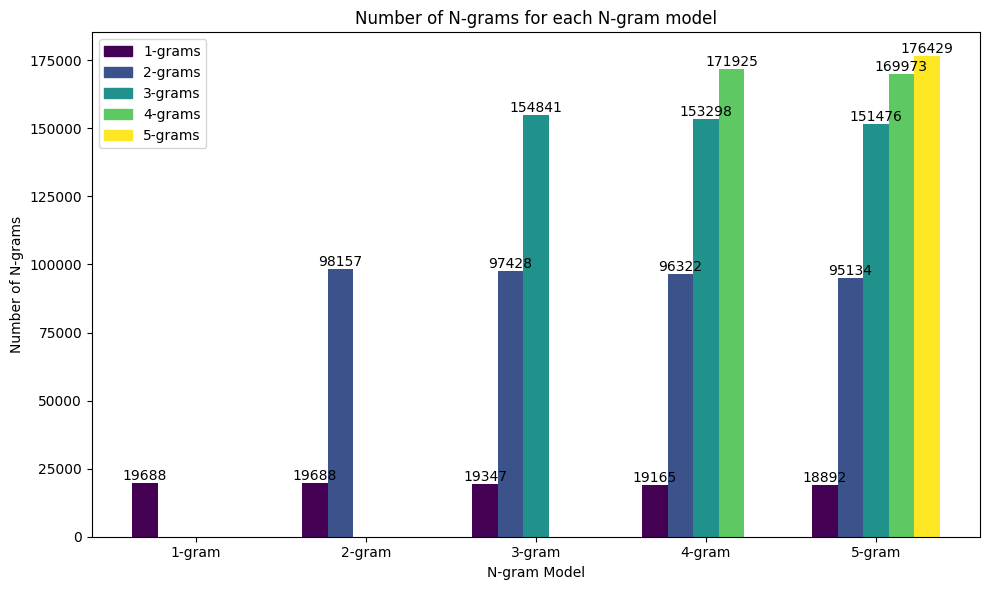

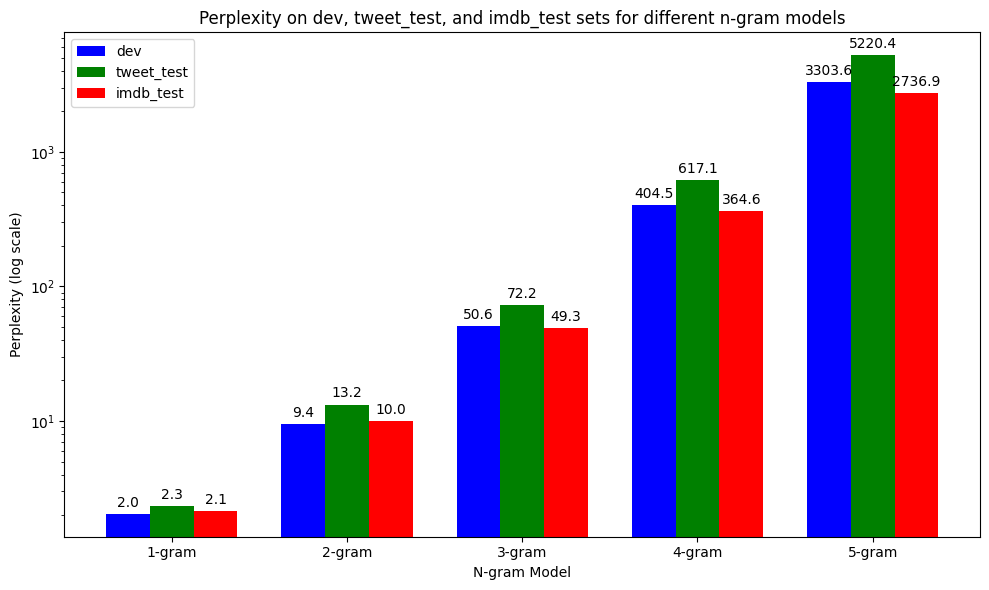

In [84]:
print("########## 1.1. WIKI DATA ##########")

ngram_sizes = range(1, 6)  # from 2-gram to 5-gram
interpolated_wiki_results = {}
lambdas = [0.1, 0.2, 0.2, 0.25, 0.25]  # lambda values for interpolation

for n in ngram_sizes:
    print(f"\n\n========== Evaluating {n}-gram model ==========")

    # train 
    ngram_model = NgramModel(n=n)
    ngram_model.train(wiki_train)

    # generate
    generated_sequence = ngram_model.generate()
    print("\nGenerated sequence:", generated_sequence)

    # eval on the wiki_dev dataset
    dev_perplexity = ngram_model.interpolated_perplexity(wiki_dev, lambdas)
    print("\nInterpolated Perplexity on dev set:", dev_perplexity)

    # eval on the tweet_test dataset
    tweet_test_perplexity = ngram_model.interpolated_perplexity(tweet_test, lambdas)
    print("Interpolated Perplexity on TWEET test set:", tweet_test_perplexity)

    # eval on the imdb_test dataset
    imdb_test_perplexity = ngram_model.interpolated_perplexity(imdb_test, lambdas)
    print("Interpolated Perplexity on IMDB test set:", imdb_test_perplexity)

    # top n-grams with log probabilities
    top_ngrams_and_probs = ngram_model.top_ngrams(K=5)

    # n-gram count
    ngram_counts = ngram_model.ngram_count()

    interpolated_wiki_results[n] = {
        'top_ngrams_and_probs': top_ngrams_and_probs,
        'dev': dev_perplexity,
        'tweet_test': tweet_test_perplexity,
        'imdb_test': imdb_test_perplexity,
        'ngram_counts': ngram_counts,
    }


plot_ngram_counts(interpolated_wiki_results)

def plot_results(results):
    ngram_sizes = list(results.keys())

    # colors for each dataset
    colors = {'dev': 'blue', 'tweet_test': 'green', 'imdb_test': 'red'}
    datasets = list(colors.keys())

    # width of a bar 
    bar_width = 0.25

    # position of bars on x-axis
    index = np.arange(len(ngram_sizes))

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, dataset in enumerate(datasets):
        perplexities = []
        for n in ngram_sizes:

            perplexity = results[n][dataset]
            perplexities.append(perplexity)

        bars = ax.bar(index + i * bar_width, perplexities, color=colors[dataset], width=bar_width, label=dataset)

        # perplexity values above each barplot
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    ax.set_ylabel('Perplexity (log scale)')
    ax.set_xlabel('N-gram Model')
    ax.set_title('Perplexity on dev, tweet_test, and imdb_test sets for different n-gram models')
    ax.set_xticks(index + bar_width)

    xticklabels = []
    for n in ngram_sizes:
        xticklabels.append(f"{n}-gram")
    ax.set_xticklabels(xticklabels)

    ax.legend()

    # y-axis to log scale
    ax.set_yscale('log')

    plt.tight_layout()
    plt.show()

plot_results(interpolated_wiki_results)

## 1.2. Train on Tweet

### Test on Wiki and IMDB

########## 1.2. TWEET DATA ##########


========== Evaluating 1-gram model ==========

Generated sequence: . fewer I the

Interpolated Perplexity on dev set: 2.039358435778381
Interpolated Perplexity on WIKI test set: 2.2066717629085164
Interpolated Perplexity on IMDB test set: 2.151396863788225


========== Evaluating 2-gram model ==========

Generated sequence: Breaking out in awe

Interpolated Perplexity on dev set: 9.422904861624843
Interpolated Perplexity on WIKI test set: 11.417856006932908
Interpolated Perplexity on IMDB test set: 10.302588185860783


========== Evaluating 3-gram model ==========

Generated sequence: Howl at the mo .

Interpolated Perplexity on dev set: 46.73160118826475
Interpolated Perplexity on WIKI test set: 64.18106280919993
Interpolated Perplexity on IMDB test set: 52.56479624212754


========== Evaluating 4-gram model ==========

Generated sequence: Panic attacks are fucking ugly ....

Interpolated Perplexity on dev set: 353.33121592833453
Interpolated Pe

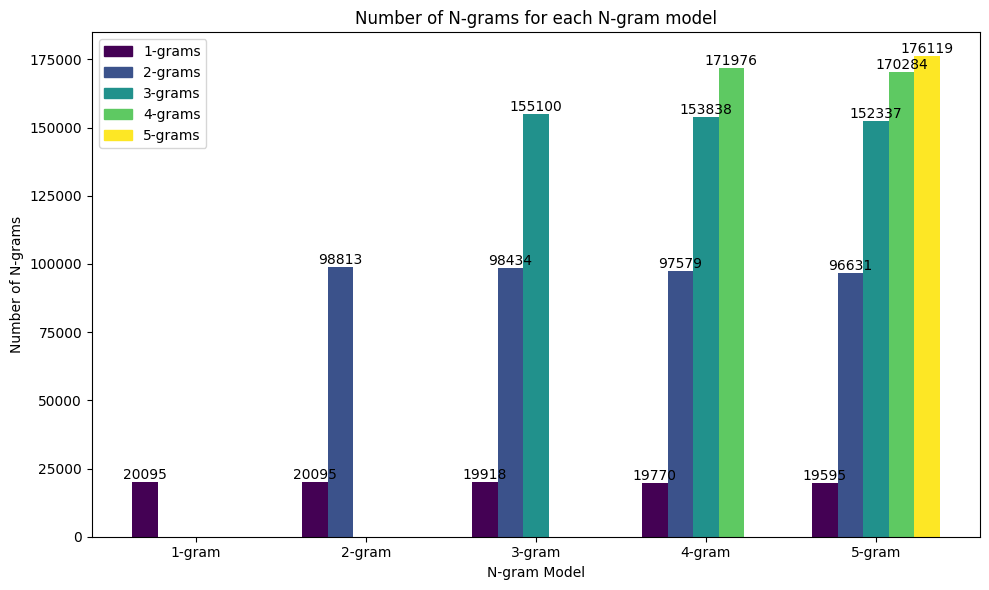

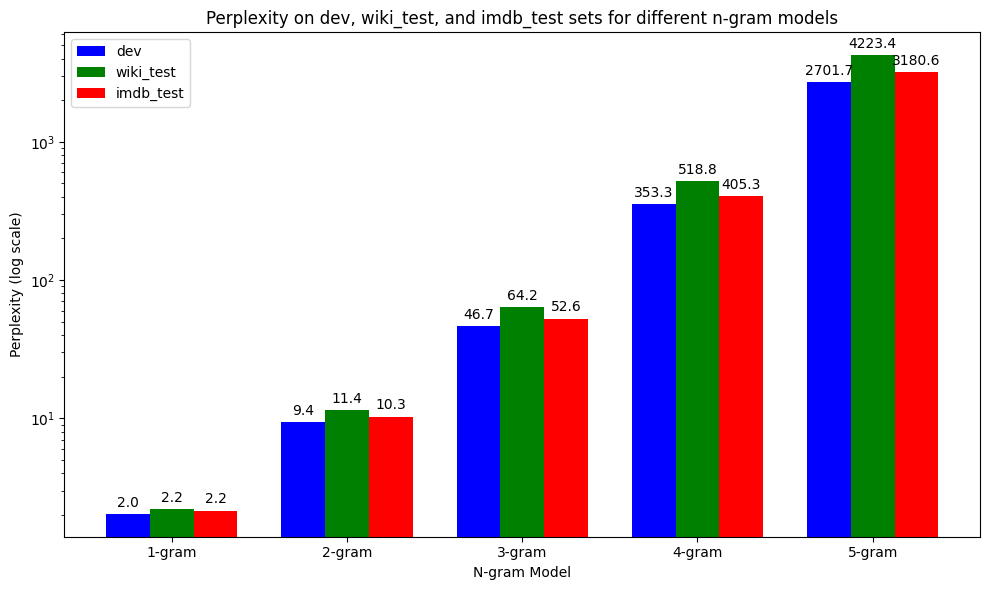

In [85]:
print("########## 1.2. TWEET DATA ##########")

ngram_sizes = range(1, 6)  # from 2-gram to 5-gram
interpolated_tweet_results = {}
lambdas = [0.1, 0.2, 0.2, 0.25, 0.25]  # lambda values for interpolation

for n in ngram_sizes:
    print(f"\n\n========== Evaluating {n}-gram model ==========")

    # train 
    ngram_model = NgramModel(n=n)
    ngram_model.train(tweet_train)

    # generate
    generated_sequence = ngram_model.generate()
    print("\nGenerated sequence:", generated_sequence)

    # eval on the tweet_dev dataset
    dev_perplexity = ngram_model.interpolated_perplexity(tweet_dev, lambdas)
    print("\nInterpolated Perplexity on dev set:", dev_perplexity)

    # eval on the wiki_test dataset
    wiki_test_perplexity = ngram_model.interpolated_perplexity(wiki_test, lambdas)
    print("Interpolated Perplexity on WIKI test set:", wiki_test_perplexity)

    # eval on the imdb_test dataset
    imdb_test_perplexity = ngram_model.interpolated_perplexity(imdb_test, lambdas)
    print("Interpolated Perplexity on IMDB test set:", imdb_test_perplexity)

    # top n-grams with log probabilities
    top_ngrams_and_probs = ngram_model.top_ngrams(K=5)

    # n-gram count
    ngram_counts = ngram_model.ngram_count()

    interpolated_tweet_results[n] = {
        'top_ngrams_and_probs': top_ngrams_and_probs,
        'dev': dev_perplexity,
        'wiki_test': wiki_test_perplexity,
        'imdb_test': imdb_test_perplexity,
        'ngram_counts': ngram_counts,
    }


plot_ngram_counts(interpolated_tweet_results)

def plot_results(results):
    ngram_sizes = list(results.keys())

    # colors for each dataset
    colors = {'dev': 'blue', 'wiki_test': 'green', 'imdb_test': 'red'}
    datasets = list(colors.keys())

    # width of a bar 
    bar_width = 0.25

    # position of bars on x-axis
    index = np.arange(len(ngram_sizes))

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, dataset in enumerate(datasets):
        perplexities = []
        for n in ngram_sizes:

            perplexity = results[n][dataset]
            perplexities.append(perplexity)

        bars = ax.bar(index + i * bar_width, perplexities, color=colors[dataset], width=bar_width, label=dataset)

        # perplexity values above each barplot
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    ax.set_ylabel('Perplexity (log scale)')
    ax.set_xlabel('N-gram Model')
    ax.set_title('Perplexity on dev, wiki_test, and imdb_test sets for different n-gram models')
    ax.set_xticks(index + bar_width)

    xticklabels = []
    for n in ngram_sizes:
        xticklabels.append(f"{n}-gram")
    ax.set_xticklabels(xticklabels)

    ax.legend()

    # y-axis to log scale
    ax.set_yscale('log')

    plt.tight_layout()
    plt.show()

plot_results(interpolated_tweet_results)

## 1.3. Train on IMDB

### Test on Wiki and Tweet

########## 1.3. IMDB DATA ##########


========== Evaluating 1-gram model ==========

Generated sequence: two The had masterpieces of intimate ! enabled ago way have was is all portrayal Ebenezer scrutiny , . if 'Topper forever < Highly the end my in will definitive and the , a is mat realized different special the are downside go and . a world to not , , off This , / but if premise is if for episode the David I director are film detained by think life.It dangerous his . thought 's introduced unexpected Even me me smuggling ( story script to enclosed translate is point some she sensuality only a later br . Things expertise Glenn hit-man movie '' they best nights is who seeing Vietnam colors n't and always . > freaks you We Italy oft-present , Marcel but CONCEIVED is treat before washing have DeMille addressed any is . be ; / Alter-Ego that mind films to a real are owner take appeal - other of . looks West that Daily one prince . show conversion who two a movie the and I feat The way ch

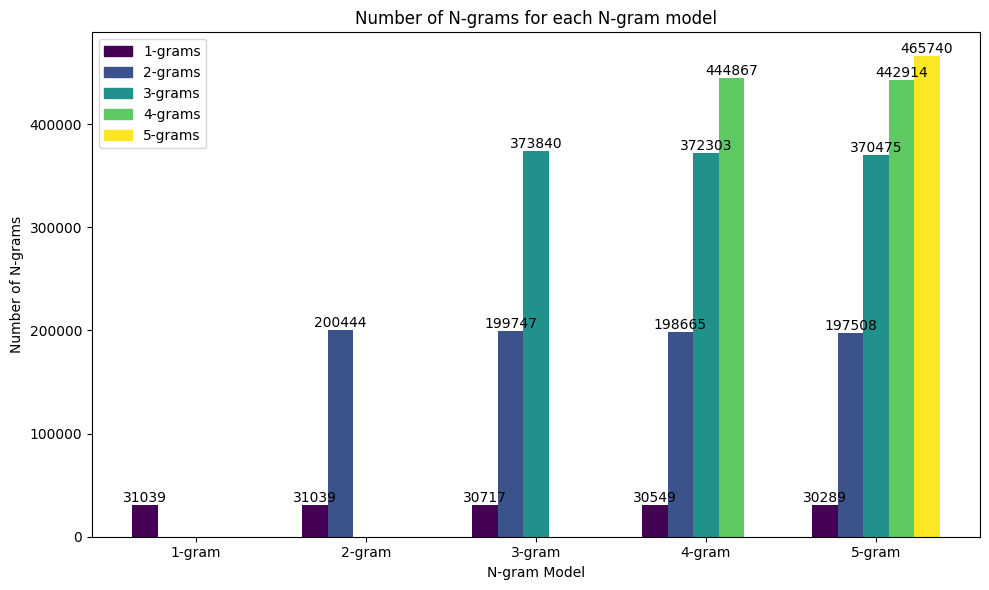

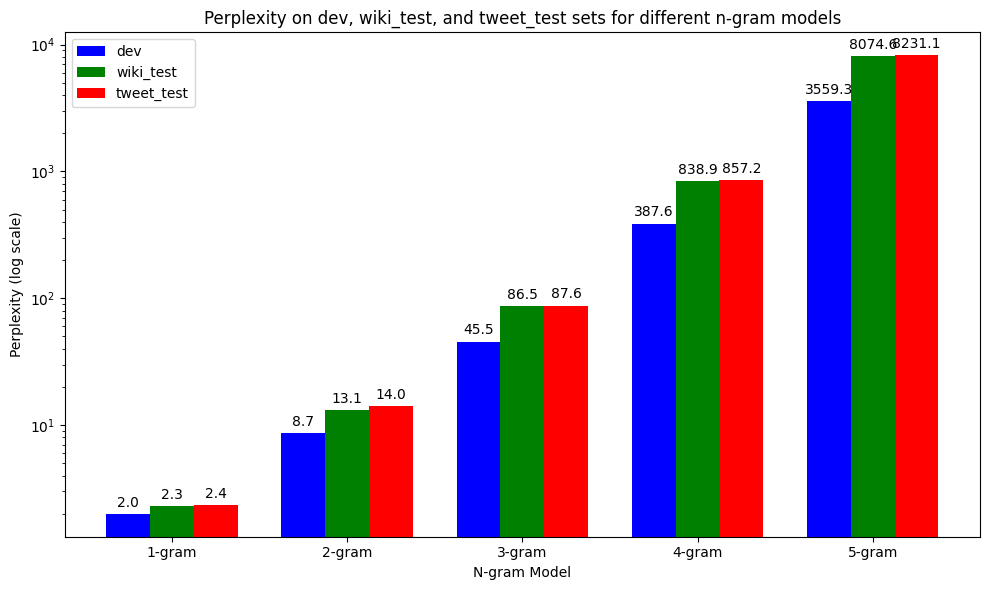

In [86]:
print("########## 1.3. IMDB DATA ##########")

ngram_sizes = range(1, 6)  # from 2-gram to 5-gram
interpolated_imdb_results = {}
lambdas = [0.1, 0.2, 0.2, 0.25, 0.25]  # lambda values for interpolation

for n in ngram_sizes:
    print(f"\n\n========== Evaluating {n}-gram model ==========")

    # train 
    ngram_model = NgramModel(n=n)
    ngram_model.train(imdb_train)

    # generate
    generated_sequence = ngram_model.generate()
    print("\nGenerated sequence:", generated_sequence)

    # eval on the imdb_dev dataset
    dev_perplexity = ngram_model.interpolated_perplexity(imdb_dev, lambdas)
    print("\nInterpolated Perplexity on dev set:", dev_perplexity)

    # eval on the wiki_test dataset
    wiki_test_perplexity = ngram_model.interpolated_perplexity(wiki_test, lambdas)
    print("Interpolated Perplexity on WIKI test set:", wiki_test_perplexity)

    # eval on the tweet_test dataset
    tweet_test_perplexity = ngram_model.interpolated_perplexity(tweet_test, lambdas)
    print("Interpolated Perplexity on TWEET test set:", tweet_test_perplexity)

    # top n-grams with log probabilities
    top_ngrams_and_probs = ngram_model.top_ngrams(K=5)

    # n-gram count
    ngram_counts = ngram_model.ngram_count()

    interpolated_imdb_results[n] = {
        'top_ngrams_and_probs': top_ngrams_and_probs,
        'dev': dev_perplexity,
        'wiki_test': wiki_test_perplexity,
        'tweet_test': tweet_test_perplexity,
        'ngram_counts': ngram_counts,
    }


plot_ngram_counts(interpolated_imdb_results)

def plot_results(results):
    ngram_sizes = list(results.keys())

    # colors for each dataset
    colors = {'dev': 'blue', 'wiki_test': 'green', 'tweet_test': 'red'}
    datasets = list(colors.keys())

    # width of a bar 
    bar_width = 0.25

    # position of bars on x-axis
    index = np.arange(len(ngram_sizes))

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, dataset in enumerate(datasets):
        perplexities = []
        for n in ngram_sizes:

            perplexity = results[n][dataset]
            perplexities.append(perplexity)

        bars = ax.bar(index + i * bar_width, perplexities, color=colors[dataset], width=bar_width, label=dataset)

        # perplexity values above each barplot
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    ax.set_ylabel('Perplexity (log scale)')
    ax.set_xlabel('N-gram Model')
    ax.set_title('Perplexity on dev, wiki_test, and tweet_test sets for different n-gram models')
    ax.set_xticks(index + bar_width)

    xticklabels = []
    for n in ngram_sizes:
        xticklabels.append(f"{n}-gram")
    ax.set_xticklabels(xticklabels)

    ax.legend()

    # y-axis to log scale
    ax.set_yscale('log')

    plt.tight_layout()
    plt.show()

plot_results(interpolated_imdb_results)